# One Pixel Attack Tutorial

![](images/pred2.png "All it takes is one pixel")

This notebook will demonstrate the one pixel attack with a few different convolutional neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.

Let's get started.

## Imports

Ensure that you have `numpy`, `pandas`, `scipy`, `matplotlib`, `tensorflow-gpu`, and `keras` installed.

In [110]:
# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10

# Custom Networks
from networks.lecun_net import LecunNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
import my_differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed = 100

from cv2 import xfeatures2d as xf
from random import random

from time import time

## Load Dataset

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [111]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [112]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can access and display any image in the dataset by its index. For instance, here is a horse.

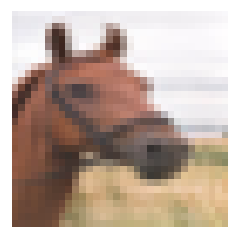

In [113]:
image = 99 # Image index in the test set
helper.plot_image(x_test[image])

## Image Perturbation

To begin, we need a function to modify one or more pixels in an image. 

We can define the perturbation of a pixel as a 5-tuple 

$$\textbf{x} = (x, y, r, g, b)$$

where $x, y$ are the coordinates of the pixel from 0 to 31, and $r,g,b$ are the red, green, and blue values from 0 to 255. Then multiple perturbations can simply be a concatenation of these tuples:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

We could instead use an array of tuples, but the optimization algorithm we will use requires it to be a flat 1-d vector.

Then the function to perturb an image can take as an input the image and $X$, and output a copy of the image with each pixel at $x_i, y_i$ modified to have the color $r_i, g_i, b_i$. To speed up computation, we will batch together an array of $X$ perturbations, denoted $X_S$.

In [114]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
            
    
    return imgs

Now we can modify the pixels of any image we want.

Let's modify our horse image by making pixel (16,16) yellow.

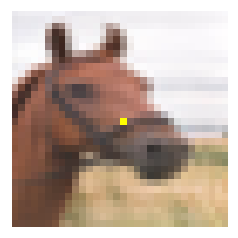

In [115]:
image = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image])[0]

helper.plot_image(image_perturbed)

## Load Models

To demonstrate the attack, we need some neural network models trained on the Cifar10 dataset. We will now load some pretrained models, which can be found in the `networks/models` directory.

It is recommended to use Keras with a GPU enabled. The code below can be used to check (if using TensorFlow).

In [116]:
# Should output /device:GPU:0
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

There are two models included in this repository, `lecun_net` and `resnet` which will be loaded from disk automatically.

Optionally, you may [download the larger, more accurate models](https://www.dropbox.com/sh/dvatkpjl0sn79kn/AAC9L4puJ_sdFUkDZfr5SFkLa?dl=0) (e.g., Capsule Network, DenseNet, etc.). Make sure to copy the models into the `networks/models/` directory. Then uncomment the lines below and run the cell to load the models of your choosing.

In [117]:
lecun_net = LecunNet()
resnet = ResNet()

models = [lecun_net, resnet]

## Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.

# lecun_net = LecunNet()
# pure_cnn = PureCnn()
# net_in_net = NetworkInNetwork()
# resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()
# capsnet = CapsNet()

# models = [lecun_net, pure_cnn, net_in_net, resnet, densenet, wide_resnet, capsnet]

Successfully loaded lecun_net
Successfully loaded resnet


Note that there are even more networks available in the `networks` directory, but must be trained before loading them here.

### Calculate Model Accuracies

After loading the models, we would like to evaluate all test images with each model to ensure that we only attack the images which have been classified correctly. The code below will also display the accuracy and number of parameters of each model.

In [118]:
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lecun_net
Evaluating resnet


name  accuracy  param_count
0  lecun_net    0.7488        62006
1     resnet    0.9231       470218

### Prediction Function

For the black-box attack, all we should care about is the inputs to the model (the images), and the outputs of the model (the prediction probabilities). No special information about the model is required; we could even swap it with a model that is not a neural network.

Define a function that runs several perturbed images on a given model and returns the model's confidence (probability output) in the target class, one confidence value per image. If the target class is the correct class, this will be the function that we want to minimize so that the model will be most confident in another class (which is incorrect). Otherwise, the target is an incorrect class and we will want to maximize it.

In [119]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

Below we can modify a pixel in an image and see how the confidence of the model changes. In almost all cases, the confidence will not change. However, for very special cases it will change drastically.

Confidence in true class bird is 0.00018887498
Prior confidence was 0.70661867


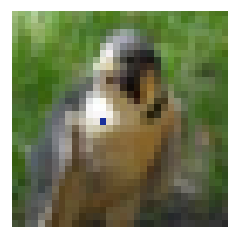

In [120]:
image = 384
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image,0]
prior_confidence = model.predict_one(x_test[image])[true_class]
confidence = predict_classes(pixel, x_test[image], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, x_test[image])[0])

## The Attack

Here we will demonstrate two variants of the one pixel attack: untargeted and targeted.

### Targeted vs. Untargeted Attacks

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to perturb an image as to minimize the confidence probability of the correct classification category and maximize the sum of the probabilities of all other categories.

The objective of a targeted attack is to cause a model to classify an image as a given  target class. We want to perturb an image as to maximize the probability of a class of our own choosing.

### Success Criterion

Define a function so that whenever a given perturbation is sufficient to fool a model, it returns `True`. This will be called the success criterion. The `targeted_attack` boolean flag will indicate whether success means maximization of the target class or minimization of the correct (target) class.

In [121]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, x_test[img])[0]

    confidence = model.predict_one(attack_image)
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if (verbose):
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True

Here we demonstrate the usage of the success criterion function. It's nearly identical to `predict_class()` as before, but also decides the success of the attack. For purposes of demonstration we assume an untargeted attack.

Confidence: 0.074600935
Prior confidence 0.50054246
Attack success: True


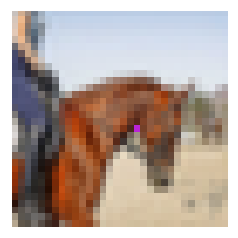

In [122]:
image = 541
pixel = np.array([17, 18, 185, 36, 215])
model = resnet

true_class = y_test[image,0]
prior_confidence = model.predict_one(x_test[image])[true_class]
success = attack_success(pixel, image, true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, x_test[image])[0])

### Attack Function

Finally, we arrive at the attack itself: how do we find the pixels that will result in a successful attack? First, formulate it as an optimization problem: in an untargeted attack, minimize the confidence of the correct class, and in a targeted attack, maximize the confidence of a target class. This is precisely our `predict_class` function.

When performing black-box optimizations such as the one pixel attack, it can be very difficult to find an efficient gradient-based optimization that will work for the problem. It would be nice to use an optimization algorithm that can find good solutions without relying on the smoothness of the function. In our case, we have discrete integer positions ranging from 0 to 31 and color intensities from 0 to 255, so the function is expected to be jagged.

For that, we use an algorithm called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). Here's an example of differential evolution optimizing the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function):

<br>

![Ackley GIF](images/Ackley.gif)

<br>

Differential evolution is a type of evolutionary algorithm where a population of candidate solutions generate offspring which compete with the rest of the population each generation according to their fitness. Each candidate solution is represented by a vector of real numbers which are the inputs to the function we would like to minimize. The lower the output of this function, the better the fitness. The algorithm works by initializing a (usually random) population of vectors, generating new offspring vectors by combining (mutating) individuals in the population, and replacing worse-performing individuals with better candidates.

In the context of the one pixel attack, our input will be a flat vector of pixel values:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

These will be encoded as floating-point values, but will be floored back into integers to calculate image perturbations. First we generate a random population of $n$ perturbations

$$\textbf{P} = (X_1, X_2, \dots, X_n)$$

Then, on each iteration we calculate $n$ new mutant children using the formula

$$X_i = X_{r1} + F (X_{r2} - X_{r3})$$

such that

$$r1 \neq r2 \neq r3$$

where $r1,r2,r3$ are random indices into our population $\textbf{P}$, and $F = 0.5$ is a mutation parameter. Basically, we pick 3 random individuals from the previous generation and recombine them to make a new candidate solution. If this candidate $X_i$ gives a lower minimum at position $i$ (i.e., the attack is closer to success), replace the old $X_i$ with this new one. This process repeats for several iterations until our stopping criterion, `attack_success`, which is when we find an image that successfully completes the attack.

<br>

See [this excellent tutorial post](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/) on how differential evolution works in greater detail. 

We will use a [slight modification](differential_evolution.py) of [Scipy's implementation of differential evolution](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html).


In [123]:
sift=xf.SIFT_create()
def getFeatureOperation(image,size):
    keypoints, descriptors = sift.detectAndCompute(image,None)
    featurePoints=[k.pt for k in keypoints]
    operation=[]
    for f in featurePoints:
        for i in range(size):
            op=[(f[0]+(random()-0.5))/32,(f[1]+(random()-0.5))/32]
            for i in range(3):
                colorChange=random()
                op.append(colorChange)
            operation.append(op)
    
    if not len(operation):
        for i in range(400):
            op=[]
            for i in range(5):
                x=random()
                op.append(x)
            operation.append(op)
    
    operation=np.array(operation)
    
    return operation

In [124]:
def MyAttack(img, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img,0]

    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    predict_fn = lambda xs: predict_classes(
        xs, x_test[img], target_class, model, target is None)
    callback_fn = lambda x, convergence: attack_success(
        x, img, target_class, model, targeted_attack, verbose)
    
    feature_operation =getFeatureOperation(x_test[img],size=10)

    # Call Scipy's Implementation of Differential Evolution
    attack_result = my_differential_evolution.my_differential_evolution(
        predict_fn, bounds, feature_operation,maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False,init='random')

    
    
    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img])[0]
    prior_probs = model.predict_one(x_test[img])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img,0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

#### Untargeted Attack

Let's look at one iteration of the untargeted attack. Here we will demonstrate a successful attack an image of a frog with the `resnet` model. We should see the confidence in the true class drop after several iterations.

Try to see if you can successfully attack other images/models. The more pixels we are allowed to modify, the more likely it is we are to find a solution for any given image.

Confidence: 0.9977639
Confidence: 0.95572317
Confidence: 0.64587617
Confidence: 0.64587617
Confidence: 0.64587617
Confidence: 0.5746588
Confidence: 0.5746588
Confidence: 0.39560816


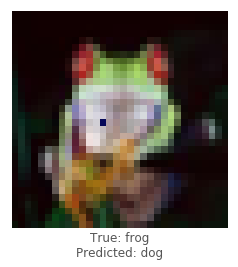

In [125]:
image = 102
pixels = 1 # Number of pixels to attack
model = resnet

_ = MyAttack(image, model, pixel_count=pixels, verbose=True)

#### Targeted Attack

In the targeted attack, we can choose which class we want a model to classify an image as. The task is much harder for the targeted attack, as we constrain the misclassification to a given class rather than any class that's not the correct one. We should see the confidence in the target class rise after several iterations.

Below we try to cause the `lecun_net` to classify an image of a `ship` as an `automobile`. Try to change the parameters and see what happens.

Attacking with target automobile
Confidence: 0.008669891
Confidence: 0.012145365
Confidence: 0.022866048
Confidence: 0.022866048
Confidence: 0.024391271
Confidence: 0.04708204
Confidence: 0.04708204
Confidence: 0.04708204
Confidence: 0.04708204
Confidence: 0.0524281
Confidence: 0.0524281
Confidence: 0.0524281
Confidence: 0.056998044
Confidence: 0.056998044
Confidence: 0.056998044
Confidence: 0.056998044
Confidence: 0.057146594
Confidence: 0.057146594
Confidence: 0.05995903
Confidence: 0.06262798
Confidence: 0.06262798
Confidence: 0.064018585
Confidence: 0.06589221
Confidence: 0.0672642
Confidence: 0.0672642
Confidence: 0.0672642
Confidence: 0.0672642
Confidence: 0.0672642
Confidence: 0.0676955
Confidence: 0.0676955
Confidence: 0.068333335
Confidence: 0.068333335
Confidence: 0.069655865
Confidence: 0.0698949
Confidence: 0.070711255
Confidence: 0.070711255
Confidence: 0.070711255
Confidence: 0.070711255
Confidence: 0.070711255
Confidence: 0.070711255
Confidence: 0.070711255
Confidence: 0

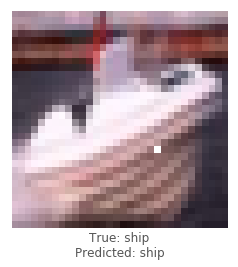

In [126]:
image = 108
target_class = 1 # Integer in range 0-9
pixels = 1
model = lecun_net

print('Attacking with target', class_names[target_class])
_ = MyAttack(image, model, target_class, pixel_count=pixels, verbose=True)

### Collect Results

Armed with all the necessary tools to conduct a one pixel attack, the final step is to collect relevant statistics on the targeted and untargeted attack. The relevant data points are what percentage of images were we able to successfully attack for a given model, and how the number of pixels affect this percentage.

We will loop through every combination of all models, perturbations of 1,3,5 pixels, images, and target classes (for the targeted attack). This will take a lot of computational resources and time, so [skip to the statistics section](#Attack-Statistics) if that's not your idea of fun.

In [127]:
def attack_all(models, samples=500, pixels=[1], targeted=False, 
               maxiter=75, popsize=400, verbose=False):
    results = []
    for model in models:
        model_results = []
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples)
        
        for pixel_count in pixels:
            for i,img in enumerate(img_samples):
                print(model.name, '- image', img, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if (targeted):
                        print('Attacking with target', class_names[target])
                        if (target == y_test[img,0]):
                            continue
                    result = MyAttack(img, model, target, pixel_count, 
                                    maxiter=maxiter, popsize=popsize, 
                                    verbose=verbose)
                    model_results.append(result)
                    
        results += model_results
        helper.checkpoint(results, targeted)
    return results

lecun_net - image 3532 - 1 / 100


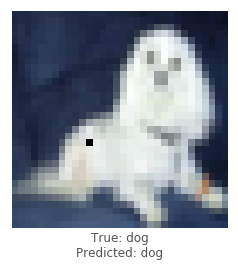

lecun_net - image 4617 - 2 / 100


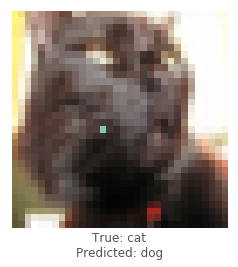

lecun_net - image 2406 - 3 / 100


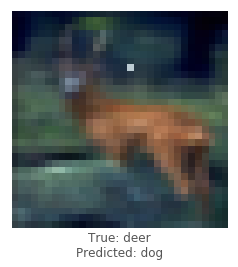

lecun_net - image 3793 - 4 / 100


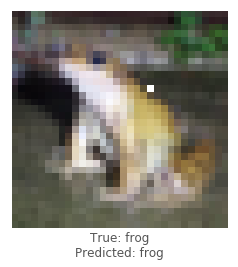

lecun_net - image 6660 - 5 / 100


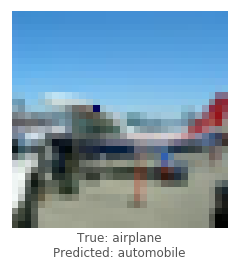

lecun_net - image 2031 - 6 / 100


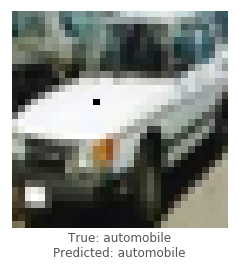

lecun_net - image 9631 - 7 / 100


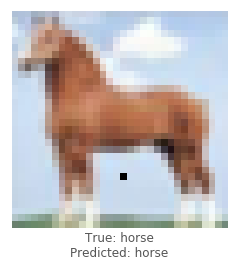

lecun_net - image 9270 - 8 / 100


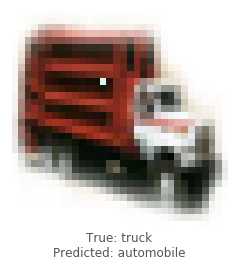

lecun_net - image 460 - 9 / 100


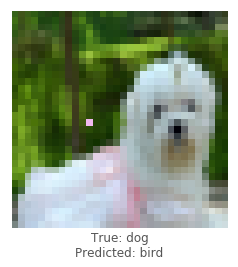

lecun_net - image 2040 - 10 / 100


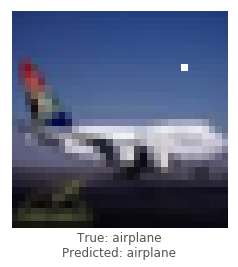

lecun_net - image 4642 - 11 / 100


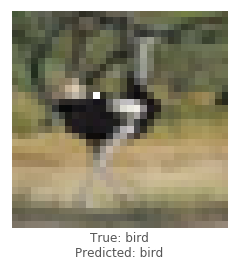

lecun_net - image 8327 - 12 / 100


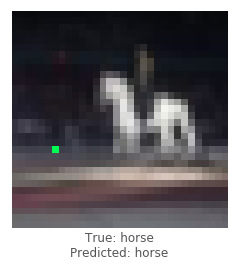

lecun_net - image 424 - 13 / 100


/media/shanicky/HDD/code/one-pixel-attack-keras/my_differential_evolution.py:601: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


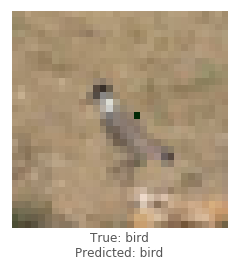

lecun_net - image 1387 - 14 / 100


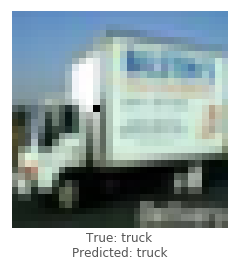

lecun_net - image 7413 - 15 / 100


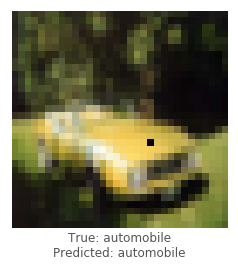

lecun_net - image 4324 - 16 / 100


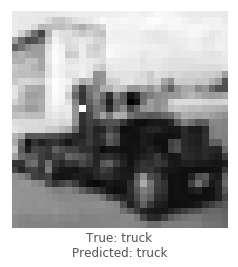

lecun_net - image 795 - 17 / 100


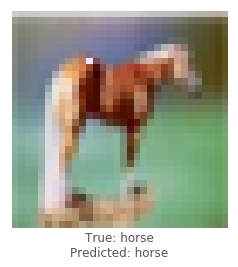

lecun_net - image 3858 - 18 / 100


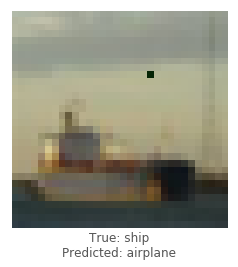

lecun_net - image 9629 - 19 / 100


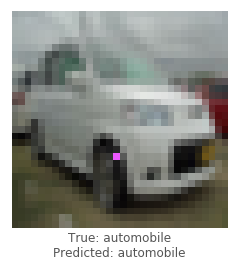

lecun_net - image 2800 - 20 / 100


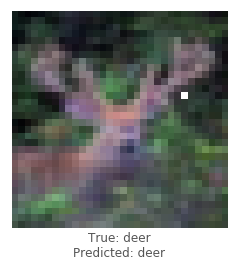

lecun_net - image 268 - 21 / 100


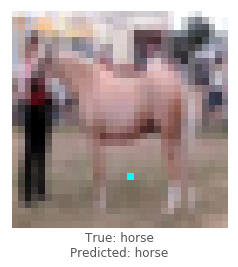

lecun_net - image 4232 - 22 / 100


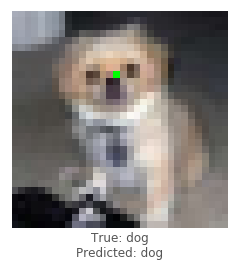

lecun_net - image 9047 - 23 / 100


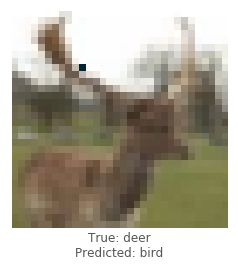

lecun_net - image 5278 - 24 / 100


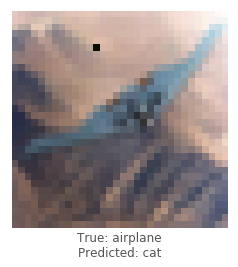

lecun_net - image 8541 - 25 / 100


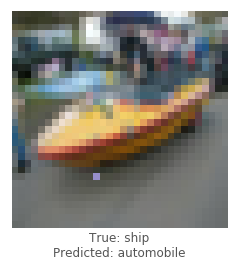

lecun_net - image 7244 - 26 / 100


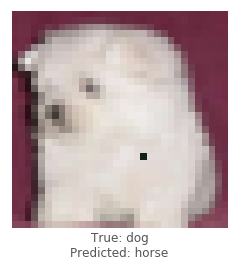

lecun_net - image 3276 - 27 / 100


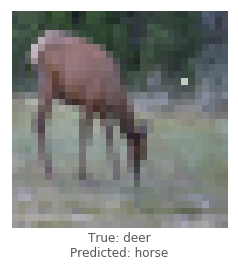

lecun_net - image 4186 - 28 / 100


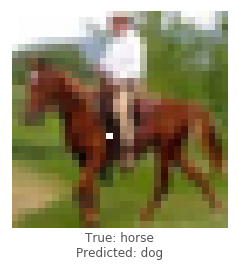

lecun_net - image 8374 - 29 / 100


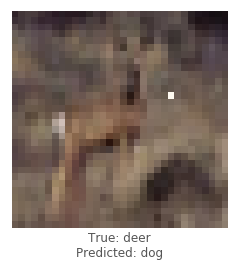

lecun_net - image 3814 - 30 / 100


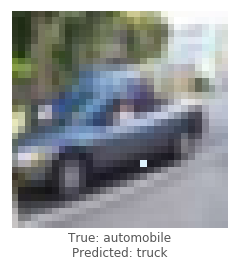

lecun_net - image 5171 - 31 / 100


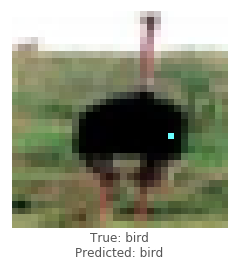

lecun_net - image 8807 - 32 / 100


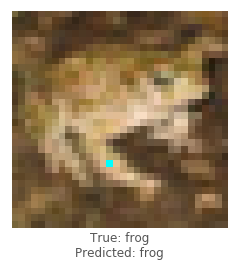

lecun_net - image 896 - 33 / 100


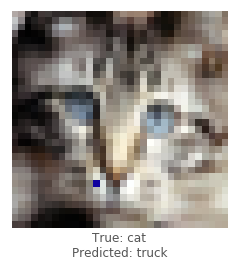

lecun_net - image 34 - 34 / 100


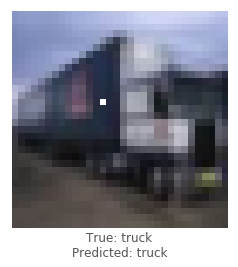

lecun_net - image 7199 - 35 / 100


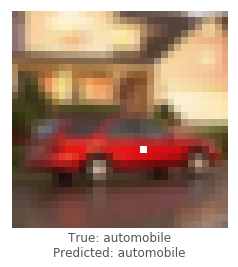

lecun_net - image 9235 - 36 / 100


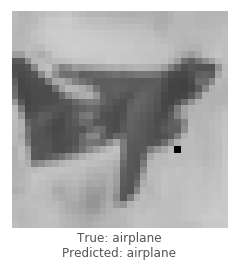

lecun_net - image 2259 - 37 / 100


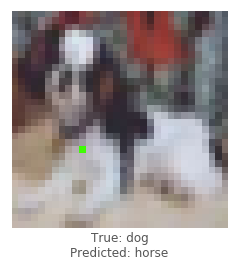

lecun_net - image 7034 - 38 / 100


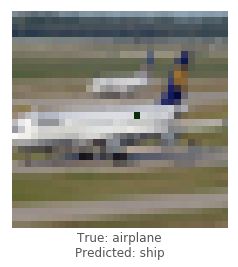

lecun_net - image 1206 - 39 / 100


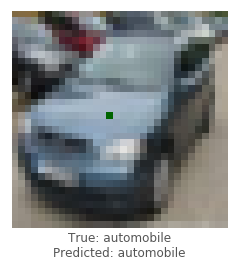

lecun_net - image 8799 - 40 / 100


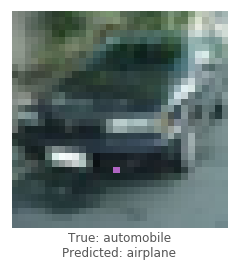

lecun_net - image 2574 - 41 / 100


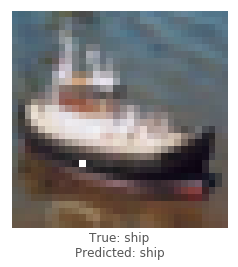

lecun_net - image 6449 - 42 / 100


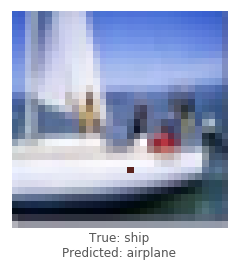

lecun_net - image 9394 - 43 / 100


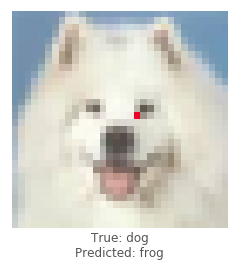

lecun_net - image 5114 - 44 / 100


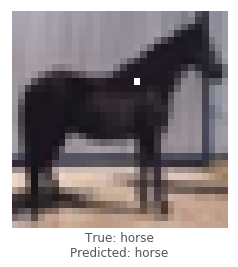

lecun_net - image 7272 - 45 / 100


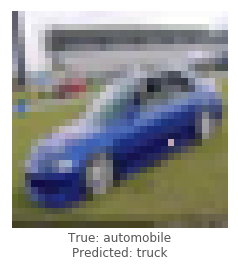

lecun_net - image 4691 - 46 / 100


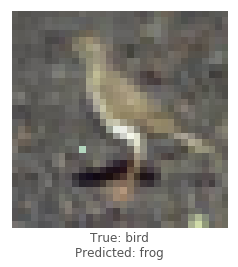

lecun_net - image 2589 - 47 / 100


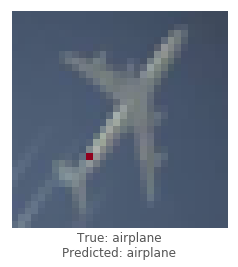

lecun_net - image 9471 - 48 / 100


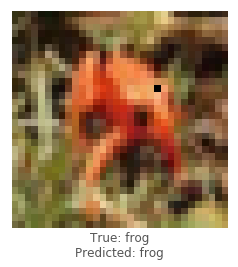

lecun_net - image 9150 - 49 / 100


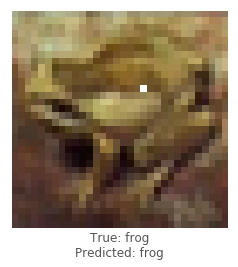

lecun_net - image 1654 - 50 / 100


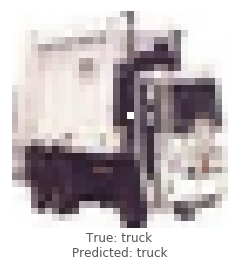

lecun_net - image 7997 - 51 / 100


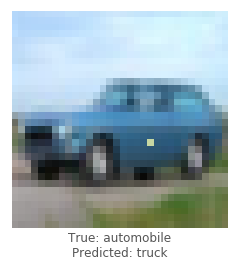

lecun_net - image 9897 - 52 / 100


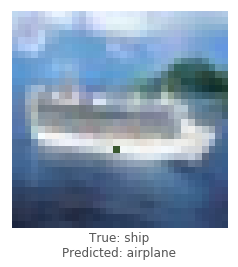

lecun_net - image 9531 - 53 / 100


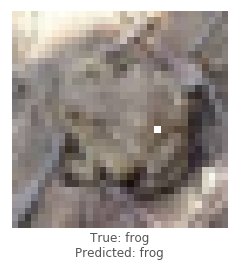

lecun_net - image 8344 - 54 / 100


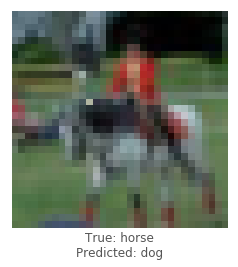

lecun_net - image 1999 - 55 / 100


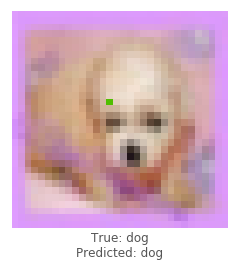

lecun_net - image 9931 - 56 / 100


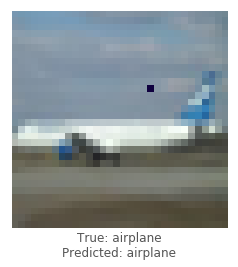

lecun_net - image 2523 - 57 / 100


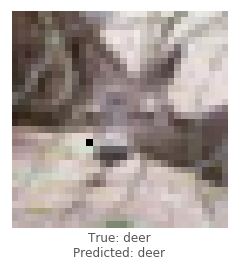

lecun_net - image 2878 - 58 / 100


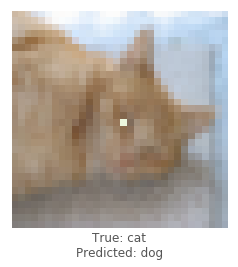

lecun_net - image 2209 - 59 / 100


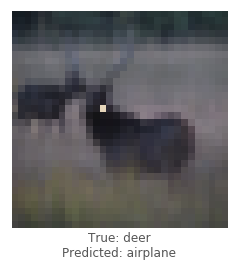

lecun_net - image 1730 - 60 / 100


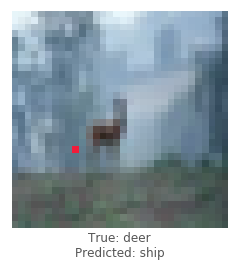

lecun_net - image 4360 - 61 / 100


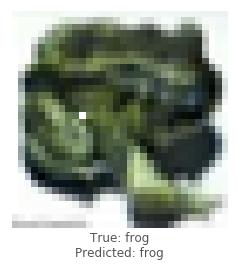

lecun_net - image 352 - 62 / 100


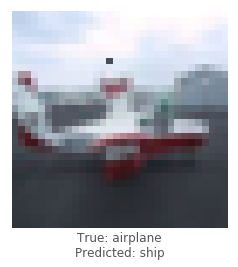

lecun_net - image 136 - 63 / 100


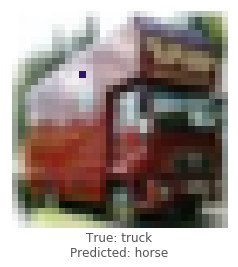

lecun_net - image 2758 - 64 / 100


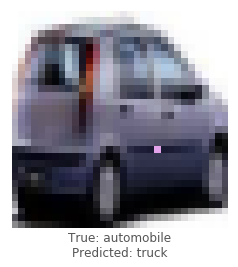

lecun_net - image 7170 - 65 / 100


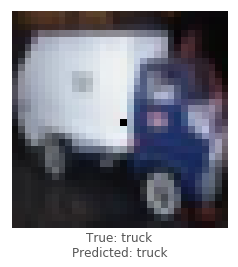

lecun_net - image 5878 - 66 / 100


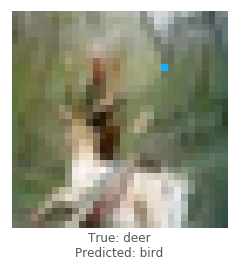

lecun_net - image 5941 - 67 / 100


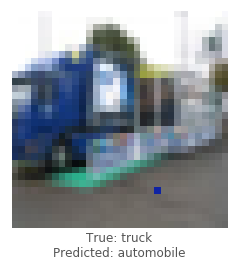

lecun_net - image 6717 - 68 / 100


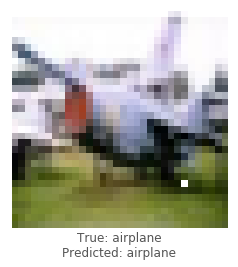

lecun_net - image 7889 - 69 / 100


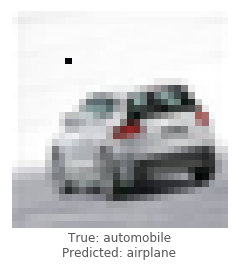

lecun_net - image 2490 - 70 / 100


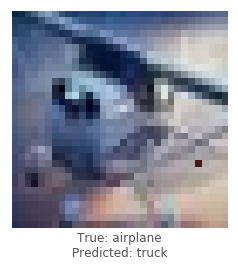

lecun_net - image 4373 - 71 / 100


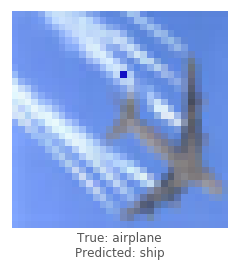

lecun_net - image 6540 - 72 / 100


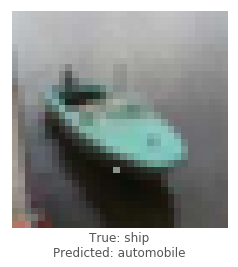

lecun_net - image 9333 - 73 / 100


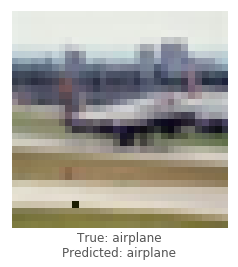

lecun_net - image 5765 - 74 / 100


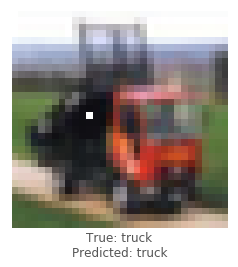

lecun_net - image 7113 - 75 / 100


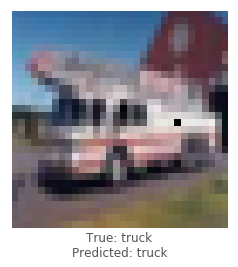

lecun_net - image 4674 - 76 / 100


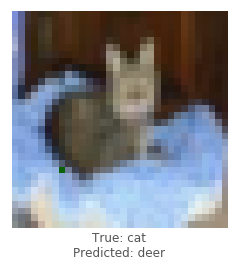

lecun_net - image 9157 - 77 / 100


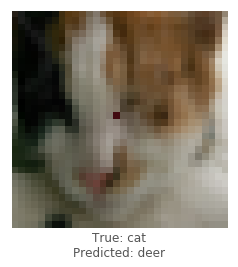

lecun_net - image 7295 - 78 / 100


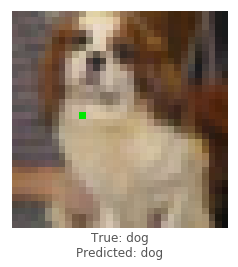

lecun_net - image 8398 - 79 / 100


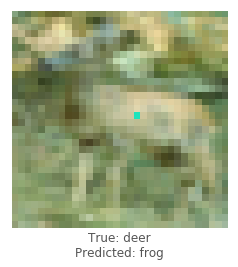

lecun_net - image 2097 - 80 / 100


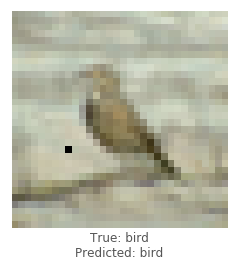

lecun_net - image 402 - 81 / 100


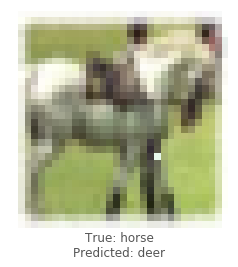

lecun_net - image 5089 - 82 / 100


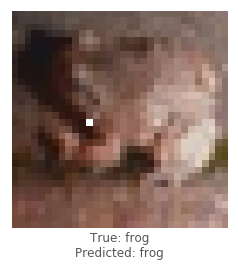

lecun_net - image 2120 - 83 / 100


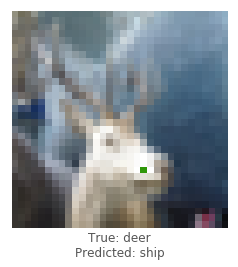

lecun_net - image 3492 - 84 / 100


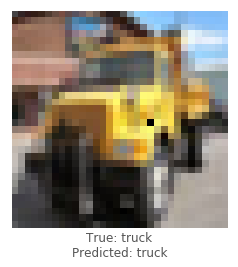

lecun_net - image 2846 - 85 / 100


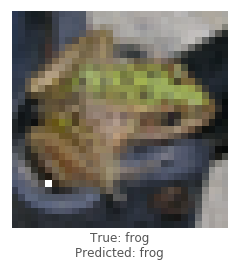

lecun_net - image 839 - 86 / 100


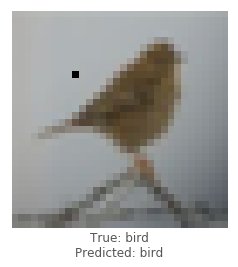

lecun_net - image 2122 - 87 / 100


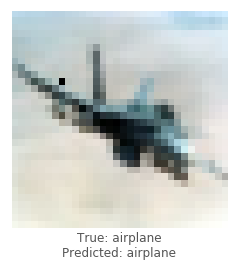

lecun_net - image 9966 - 88 / 100


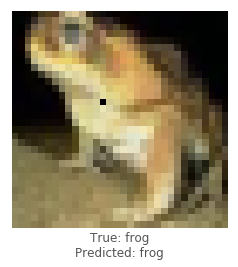

lecun_net - image 7346 - 89 / 100


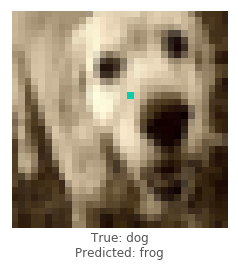

lecun_net - image 3418 - 90 / 100


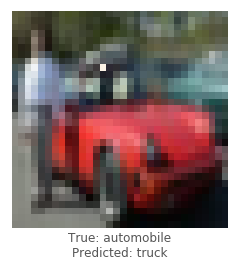

lecun_net - image 6392 - 91 / 100


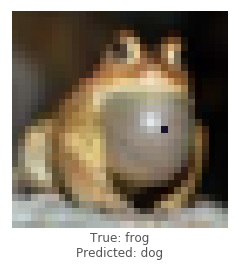

lecun_net - image 3892 - 92 / 100


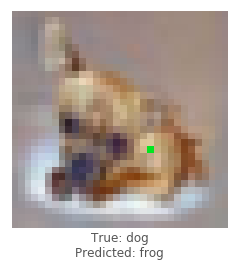

lecun_net - image 3984 - 93 / 100


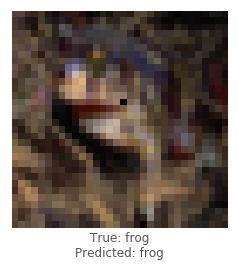

lecun_net - image 7476 - 94 / 100


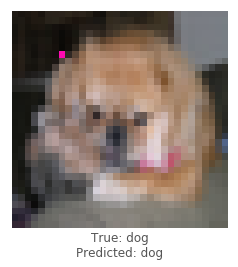

lecun_net - image 4022 - 95 / 100


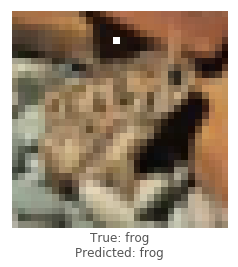

lecun_net - image 1541 - 96 / 100


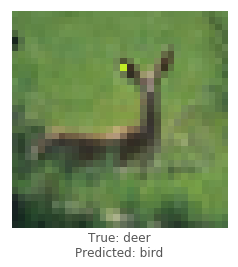

lecun_net - image 6227 - 97 / 100


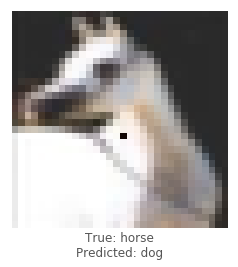

lecun_net - image 345 - 98 / 100


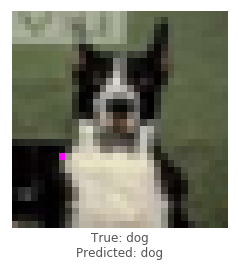

lecun_net - image 5067 - 99 / 100


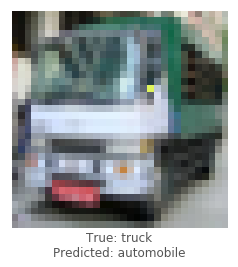

lecun_net - image 6313 - 100 / 100


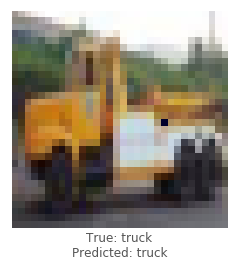

resnet - image 2020 - 1 / 100


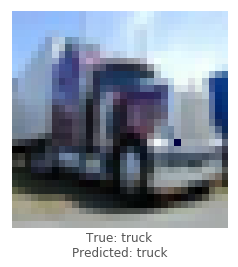

resnet - image 3430 - 2 / 100


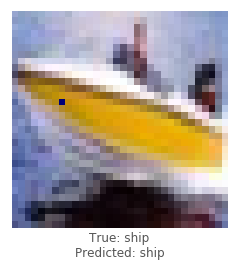

resnet - image 8190 - 3 / 100


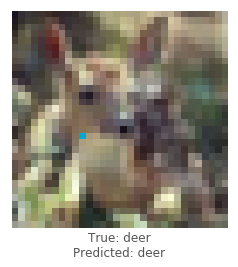

resnet - image 7178 - 4 / 100


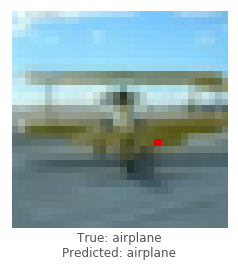

resnet - image 3372 - 5 / 100


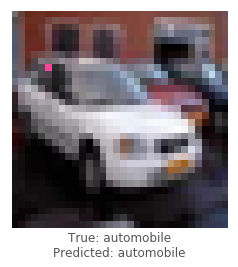

resnet - image 4137 - 6 / 100


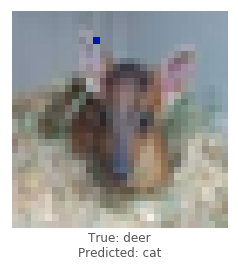

resnet - image 5642 - 7 / 100


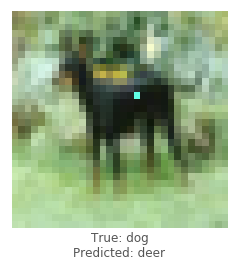

resnet - image 7054 - 8 / 100


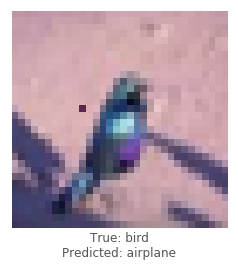

resnet - image 9072 - 9 / 100


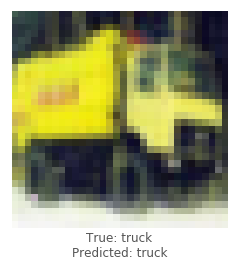

resnet - image 1121 - 10 / 100


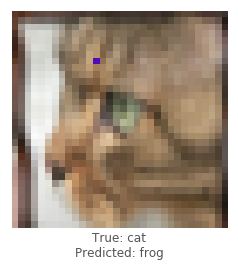

resnet - image 7022 - 11 / 100


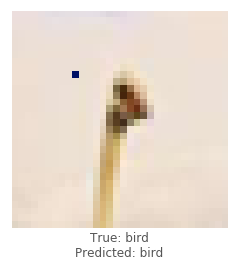

resnet - image 7296 - 12 / 100


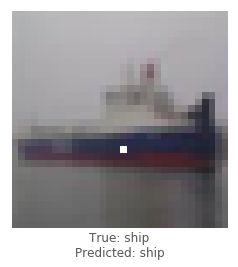

resnet - image 6683 - 13 / 100


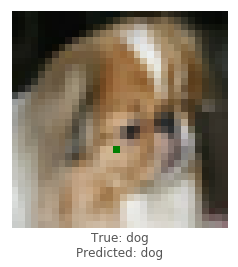

resnet - image 7070 - 14 / 100


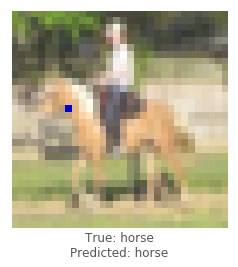

resnet - image 9673 - 15 / 100


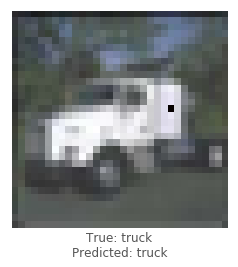

resnet - image 4660 - 16 / 100


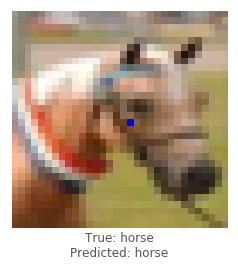

resnet - image 3718 - 17 / 100


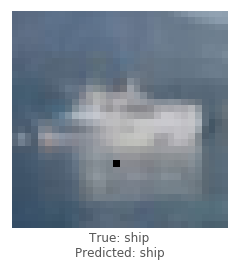

resnet - image 5733 - 18 / 100


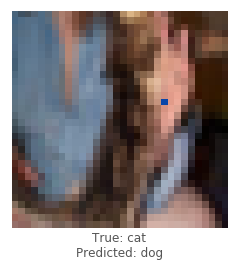

resnet - image 943 - 19 / 100


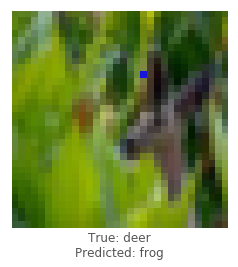

resnet - image 2324 - 20 / 100


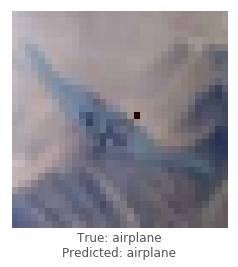

resnet - image 6096 - 21 / 100


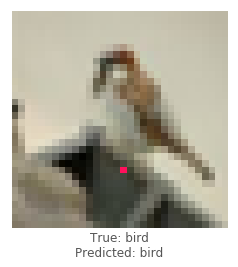

resnet - image 3864 - 22 / 100


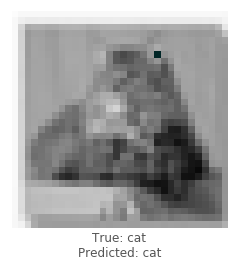

resnet - image 4923 - 23 / 100


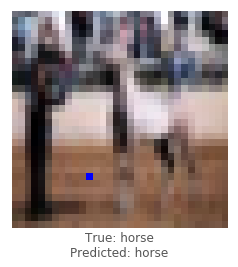

resnet - image 6130 - 24 / 100


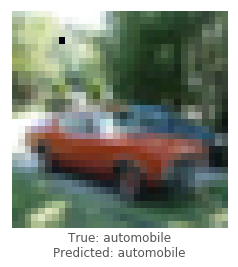

resnet - image 486 - 25 / 100


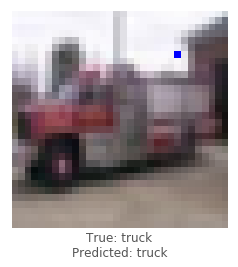

resnet - image 3103 - 26 / 100


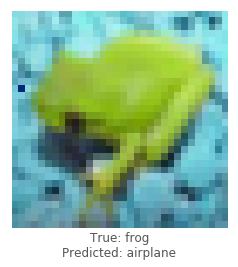

resnet - image 1206 - 27 / 100


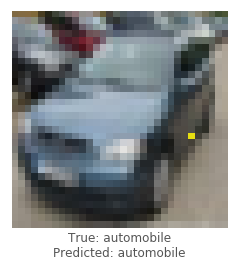

resnet - image 808 - 28 / 100


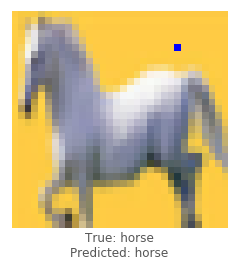

resnet - image 6410 - 29 / 100


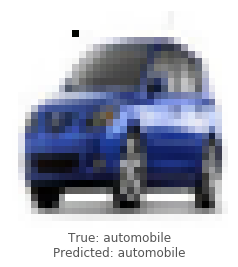

resnet - image 7871 - 30 / 100


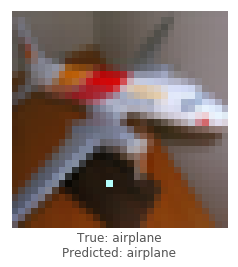

resnet - image 7921 - 31 / 100


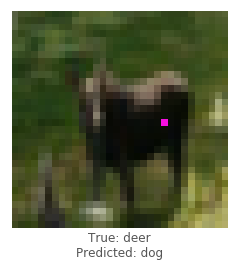

resnet - image 1101 - 32 / 100


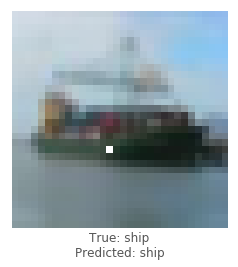

resnet - image 9270 - 33 / 100


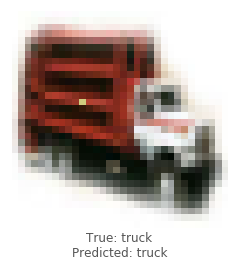

resnet - image 8978 - 34 / 100


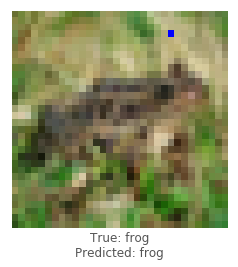

resnet - image 4948 - 35 / 100


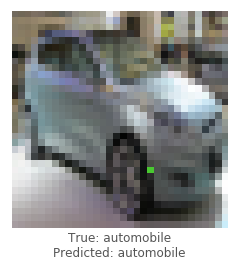

resnet - image 5026 - 36 / 100


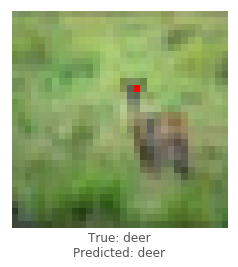

resnet - image 3106 - 37 / 100


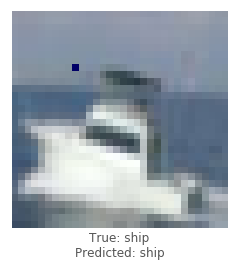

resnet - image 4695 - 38 / 100


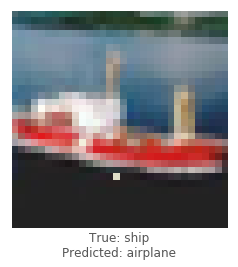

resnet - image 1067 - 39 / 100


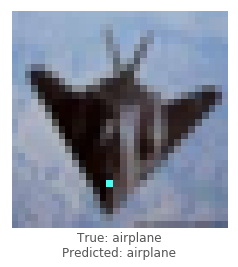

resnet - image 291 - 40 / 100


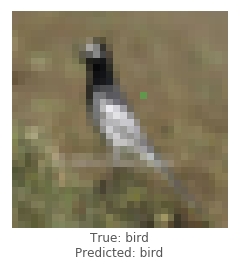

resnet - image 6696 - 41 / 100


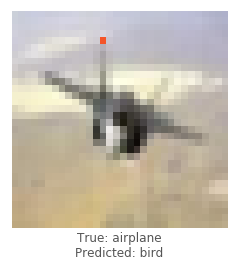

resnet - image 9944 - 42 / 100


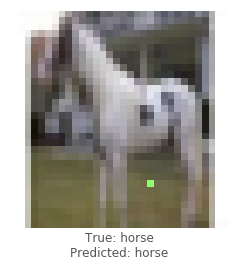

resnet - image 352 - 43 / 100


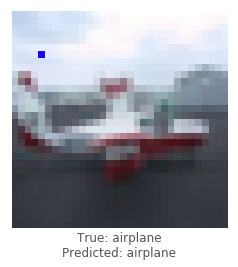

resnet - image 2060 - 44 / 100


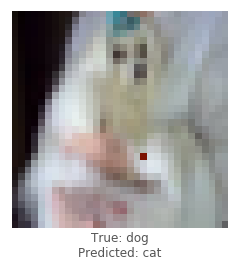

resnet - image 7133 - 45 / 100


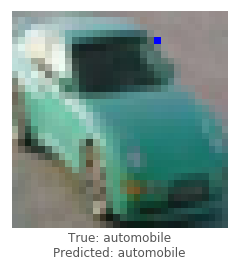

resnet - image 1226 - 46 / 100


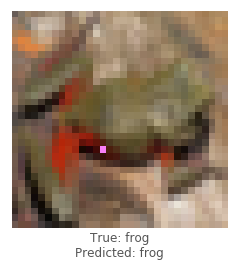

resnet - image 4909 - 47 / 100


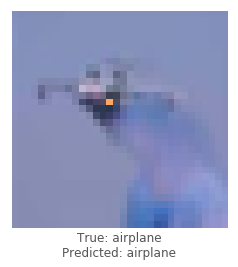

resnet - image 6806 - 48 / 100


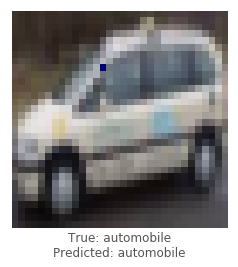

resnet - image 5814 - 49 / 100


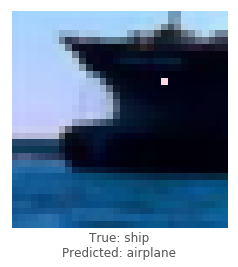

resnet - image 6718 - 50 / 100


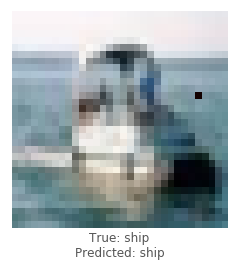

resnet - image 332 - 51 / 100


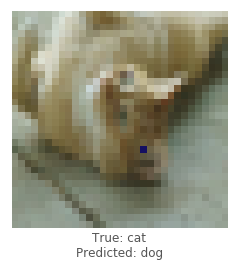

resnet - image 6322 - 52 / 100


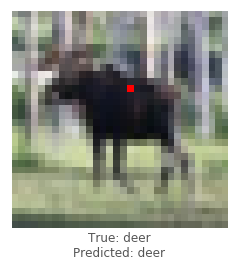

resnet - image 9358 - 53 / 100


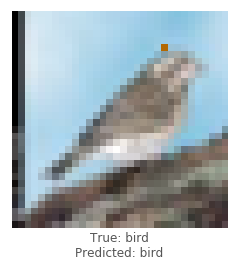

resnet - image 2344 - 54 / 100


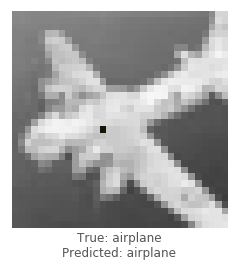

resnet - image 8380 - 55 / 100


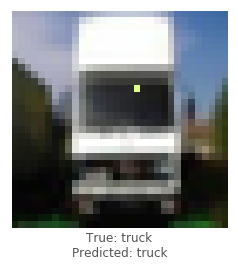

resnet - image 4953 - 56 / 100


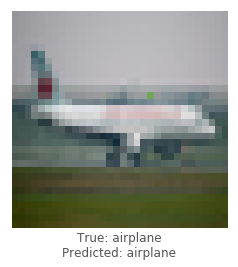

resnet - image 4499 - 57 / 100


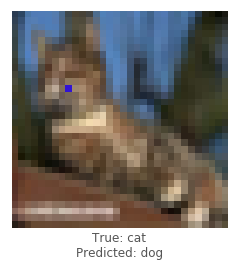

resnet - image 5853 - 58 / 100


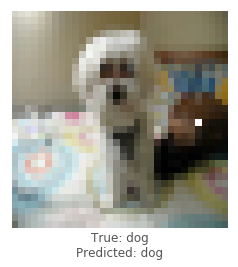

resnet - image 8490 - 59 / 100


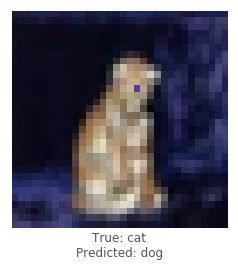

resnet - image 1733 - 60 / 100


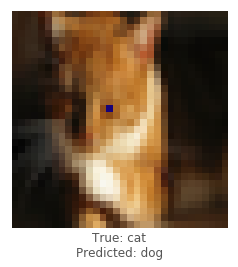

resnet - image 8540 - 61 / 100


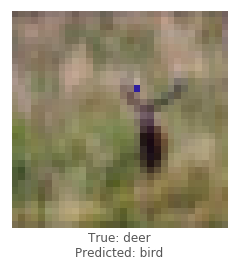

resnet - image 4756 - 62 / 100


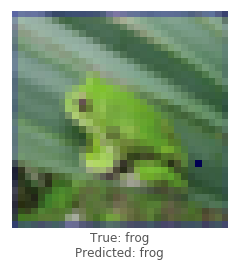

resnet - image 191 - 63 / 100


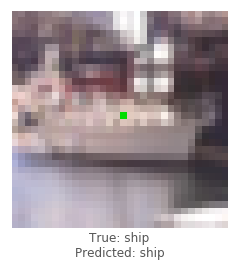

resnet - image 9523 - 64 / 100


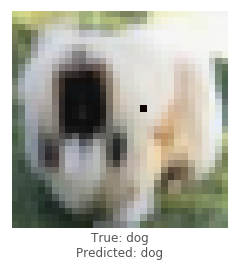

resnet - image 6943 - 65 / 100


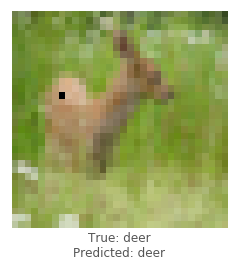

resnet - image 2404 - 66 / 100


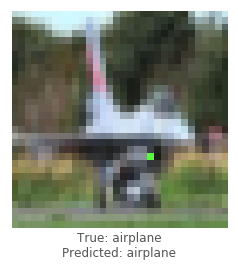

resnet - image 3463 - 67 / 100


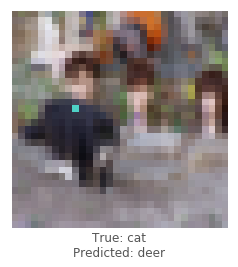

resnet - image 2552 - 68 / 100


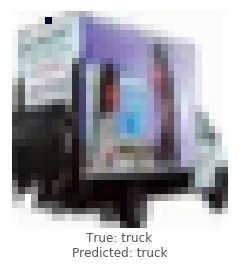

resnet - image 8121 - 69 / 100


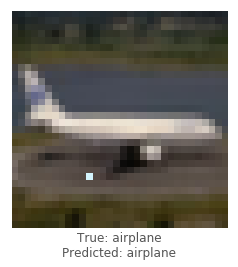

resnet - image 8314 - 70 / 100


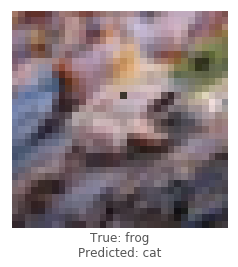

resnet - image 5219 - 71 / 100


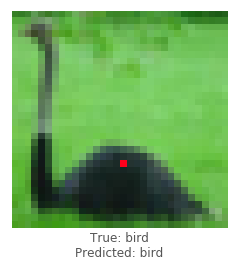

resnet - image 3167 - 72 / 100


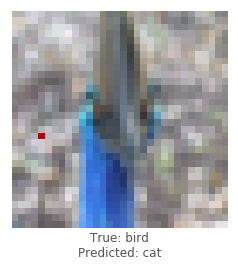

resnet - image 7586 - 73 / 100


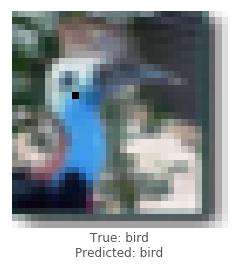

resnet - image 3051 - 74 / 100


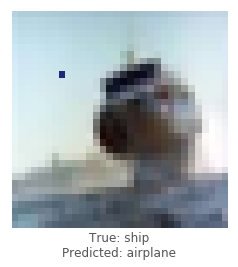

resnet - image 3557 - 75 / 100


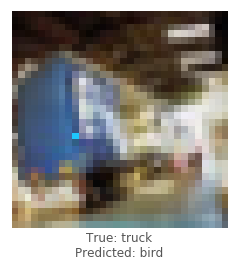

resnet - image 6076 - 76 / 100


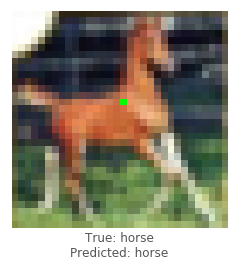

resnet - image 4554 - 77 / 100


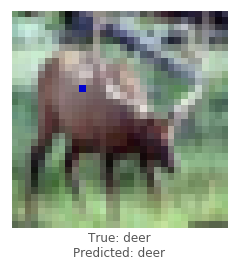

resnet - image 8523 - 78 / 100


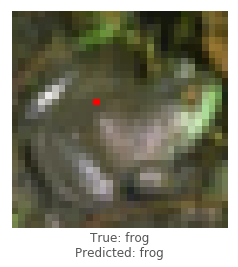

resnet - image 9605 - 79 / 100


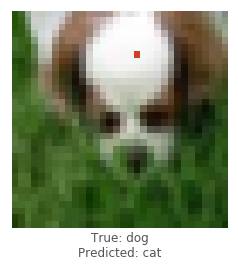

resnet - image 1994 - 80 / 100


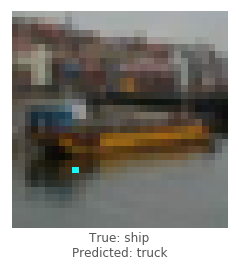

resnet - image 5386 - 81 / 100


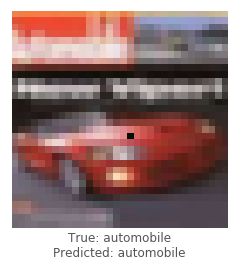

resnet - image 719 - 82 / 100


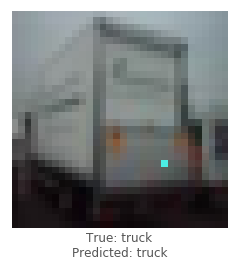

resnet - image 6221 - 83 / 100


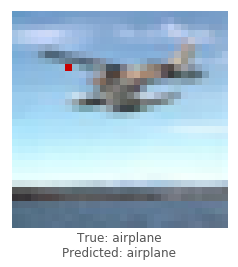

resnet - image 8099 - 84 / 100


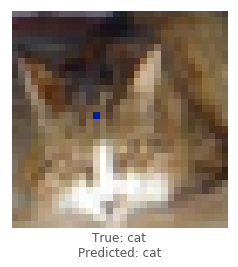

resnet - image 8347 - 85 / 100


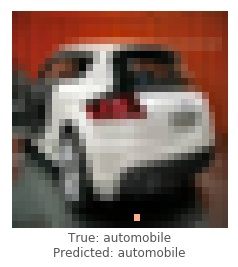

resnet - image 7249 - 86 / 100


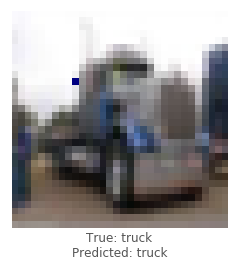

resnet - image 5888 - 87 / 100


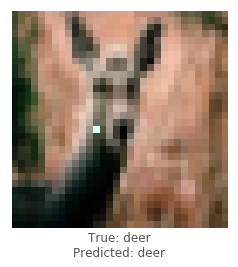

resnet - image 3526 - 88 / 100


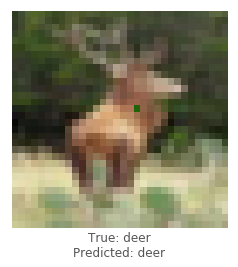

resnet - image 3363 - 89 / 100


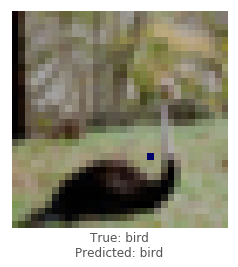

resnet - image 5249 - 90 / 100


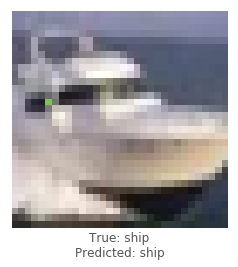

resnet - image 3502 - 91 / 100


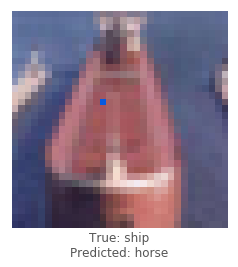

resnet - image 4493 - 92 / 100


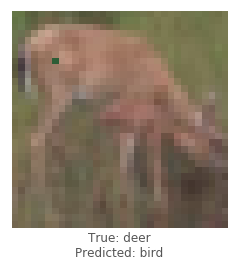

resnet - image 163 - 93 / 100


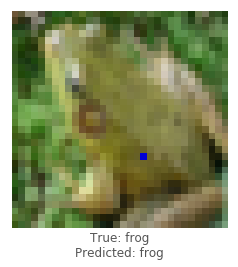

resnet - image 4873 - 94 / 100


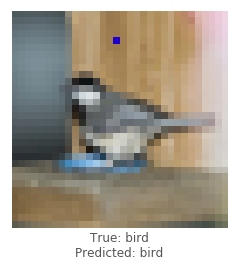

resnet - image 3027 - 95 / 100


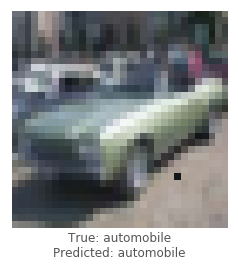

resnet - image 9525 - 96 / 100


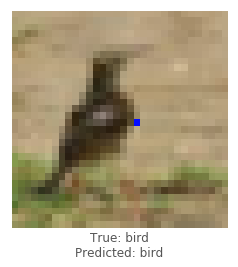

resnet - image 9924 - 97 / 100


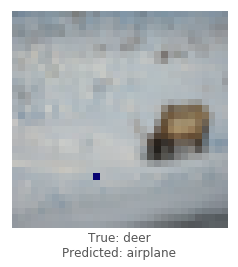

resnet - image 7944 - 98 / 100


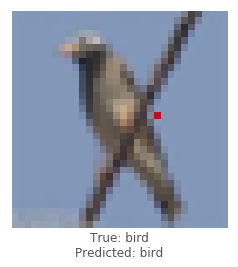

resnet - image 6286 - 99 / 100


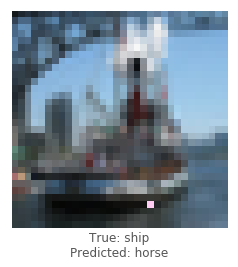

resnet - image 994 - 100 / 100


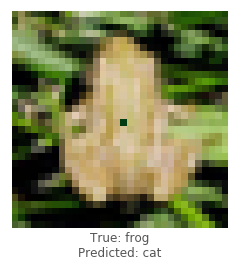

In [128]:
time_start=time()
untargeted = attack_all(models, samples=100, targeted=False)
time_end=time()

In [139]:
untargeted_time=time_end-time_start
print(untargeted_time)

1468.496487379074


lecun_net - image 4529 - 1 / 10
Attacking with target airplane


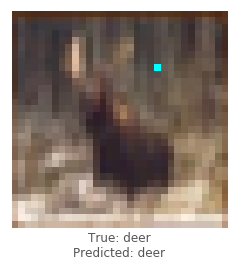

Attacking with target automobile


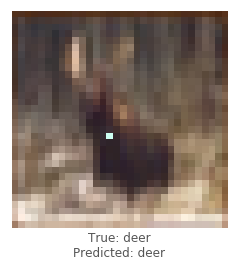

Attacking with target bird


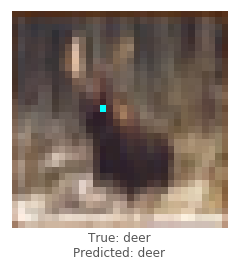

Attacking with target cat


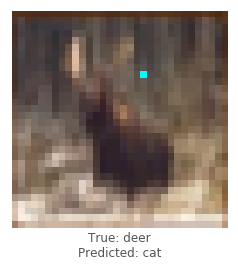

Attacking with target deer
Attacking with target dog


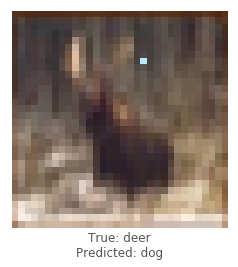

Attacking with target frog


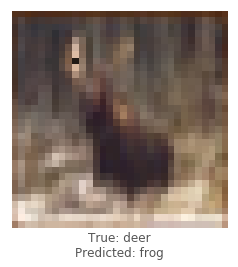

Attacking with target horse


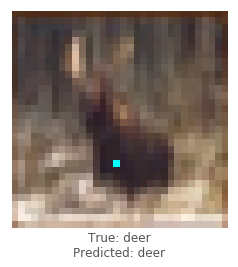

Attacking with target ship


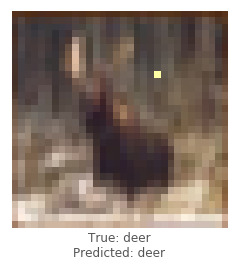

Attacking with target truck


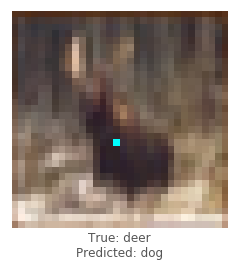

lecun_net - image 7178 - 2 / 10
Attacking with target airplane
Attacking with target automobile


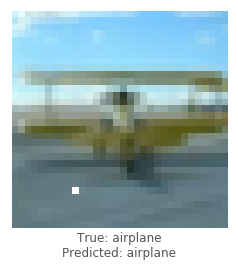

Attacking with target bird


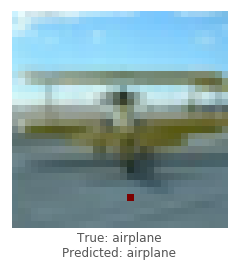

Attacking with target cat


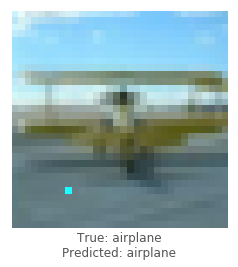

Attacking with target deer


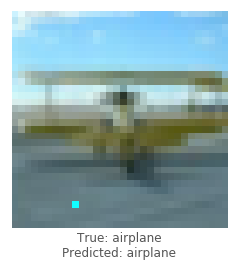

Attacking with target dog


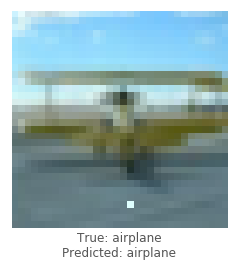

Attacking with target frog


/media/shanicky/HDD/code/one-pixel-attack-keras/my_differential_evolution.py:601: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


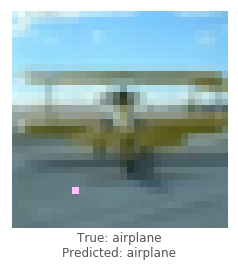

Attacking with target horse


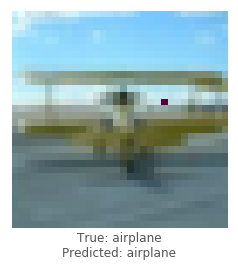

Attacking with target ship


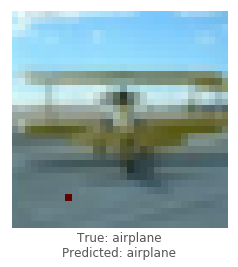

Attacking with target truck


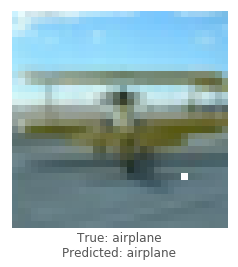

lecun_net - image 7141 - 3 / 10
Attacking with target airplane


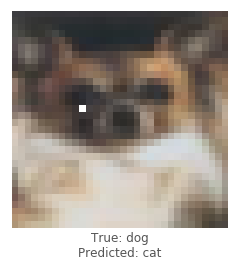

Attacking with target automobile


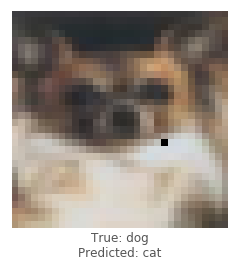

Attacking with target bird


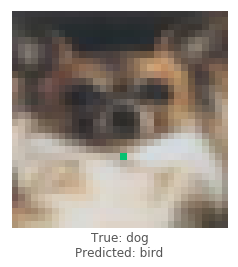

Attacking with target cat


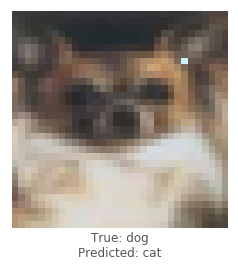

Attacking with target deer


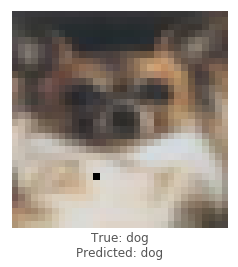

Attacking with target dog
Attacking with target frog


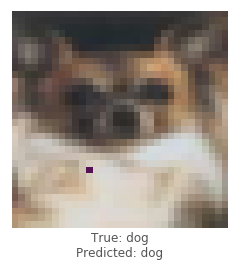

Attacking with target horse


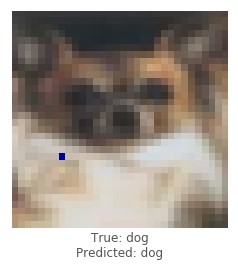

Attacking with target ship


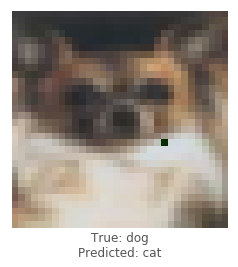

Attacking with target truck


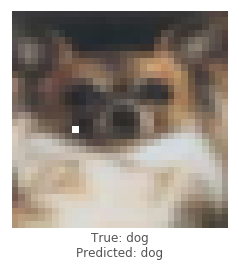

lecun_net - image 2266 - 4 / 10
Attacking with target airplane


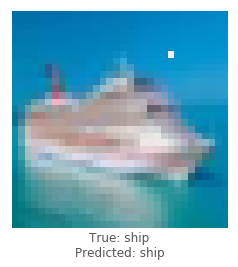

Attacking with target automobile


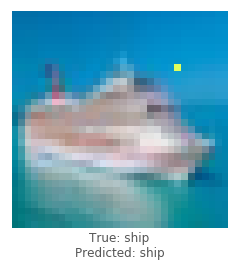

Attacking with target bird


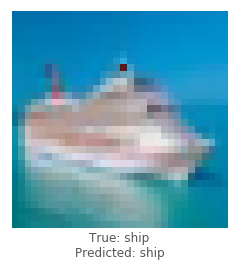

Attacking with target cat


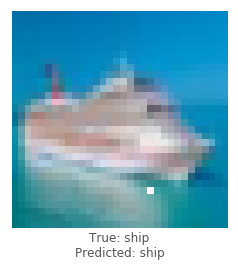

Attacking with target deer


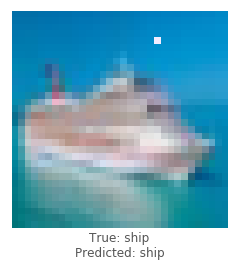

Attacking with target dog


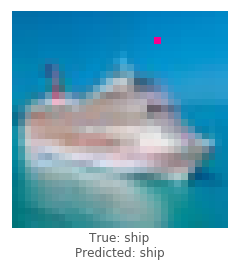

Attacking with target frog


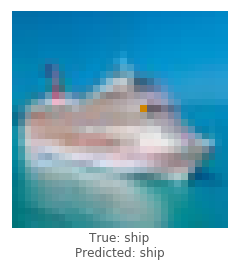

Attacking with target horse


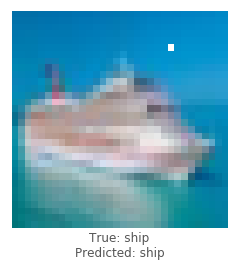

Attacking with target ship
Attacking with target truck


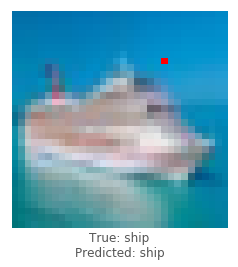

lecun_net - image 1633 - 5 / 10
Attacking with target airplane


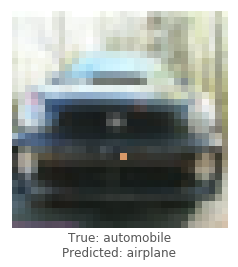

Attacking with target automobile
Attacking with target bird


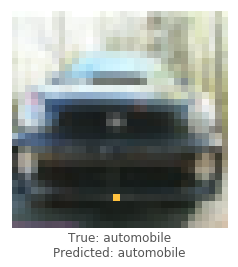

Attacking with target cat


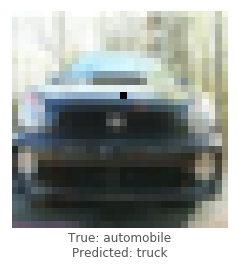

Attacking with target deer


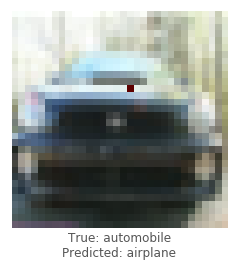

Attacking with target dog


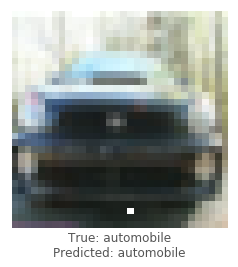

Attacking with target frog


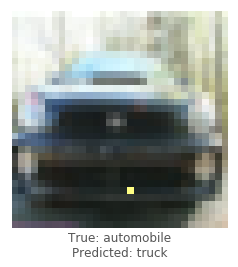

Attacking with target horse


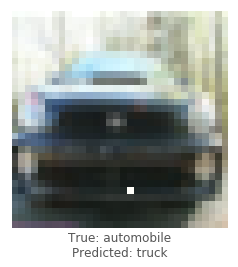

Attacking with target ship


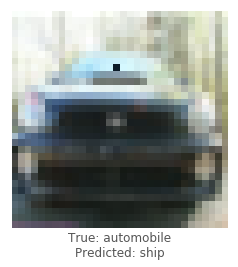

Attacking with target truck


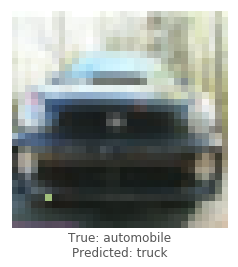

lecun_net - image 7788 - 6 / 10
Attacking with target airplane


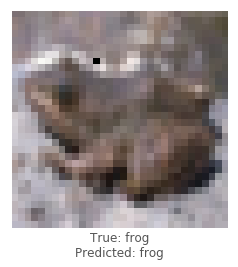

Attacking with target automobile


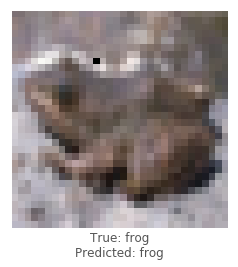

Attacking with target bird


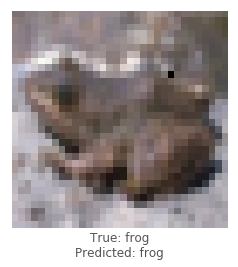

Attacking with target cat


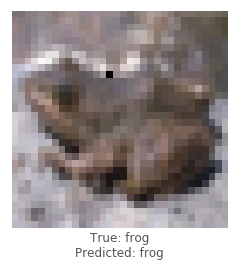

Attacking with target deer


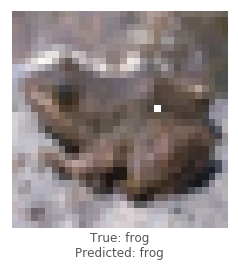

Attacking with target dog


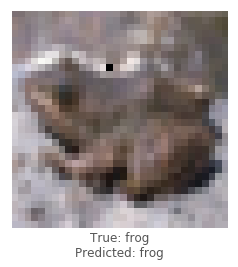

Attacking with target frog
Attacking with target horse


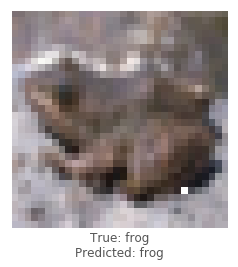

Attacking with target ship


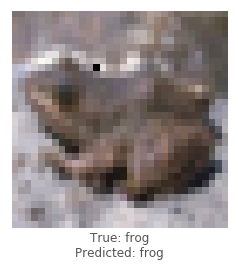

Attacking with target truck


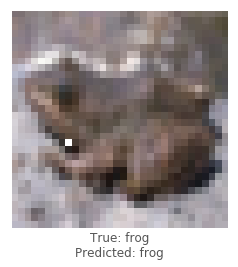

lecun_net - image 6057 - 7 / 10
Attacking with target airplane
Attacking with target automobile


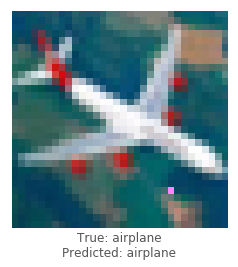

Attacking with target bird


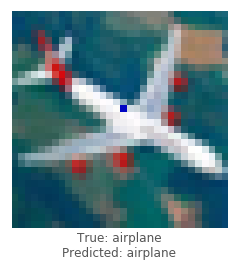

Attacking with target cat


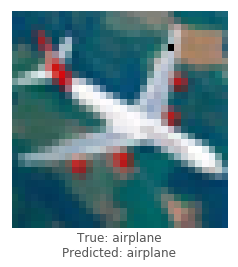

Attacking with target deer


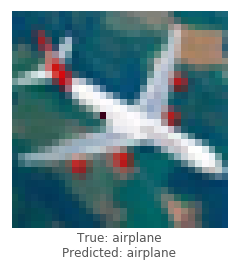

Attacking with target dog


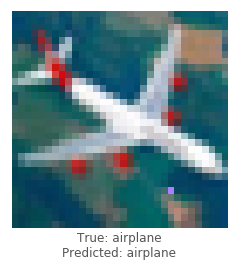

Attacking with target frog


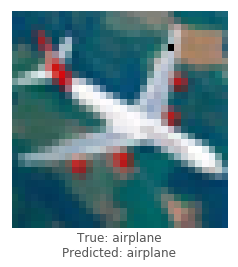

Attacking with target horse


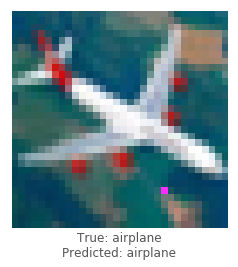

Attacking with target ship


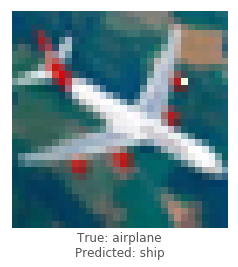

Attacking with target truck


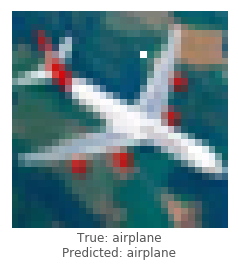

lecun_net - image 9612 - 8 / 10
Attacking with target airplane


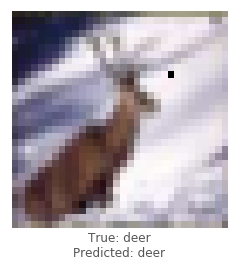

Attacking with target automobile


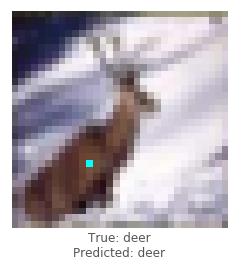

Attacking with target bird


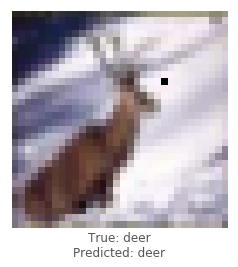

Attacking with target cat


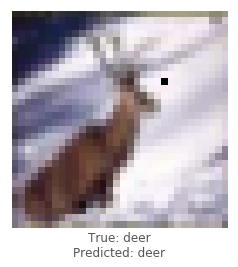

Attacking with target deer
Attacking with target dog


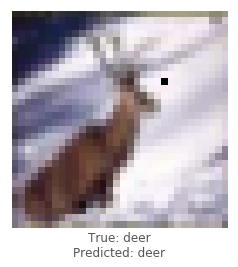

Attacking with target frog


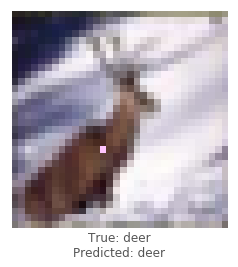

Attacking with target horse


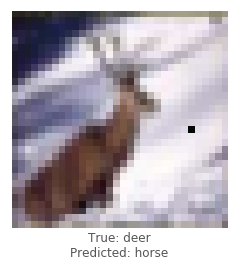

Attacking with target ship


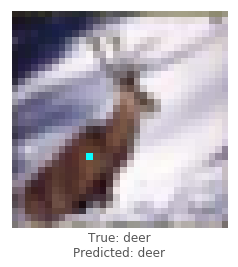

Attacking with target truck


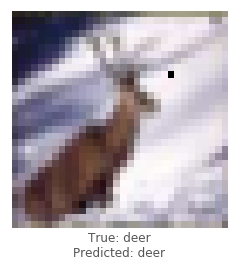

lecun_net - image 7574 - 9 / 10
Attacking with target airplane


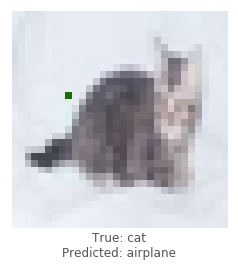

Attacking with target automobile


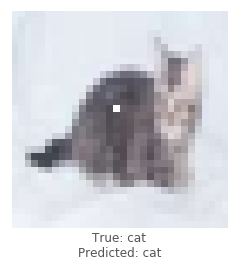

Attacking with target bird


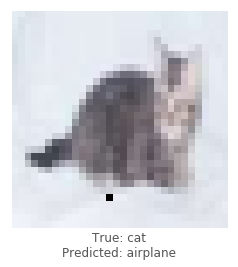

Attacking with target cat
Attacking with target deer


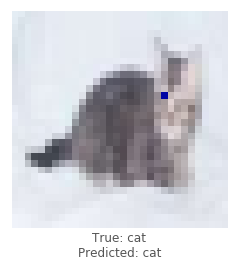

Attacking with target dog


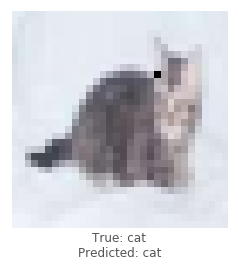

Attacking with target frog


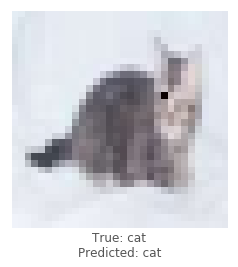

Attacking with target horse


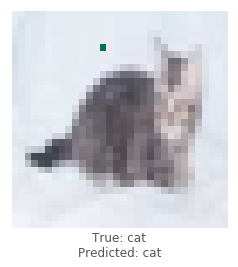

Attacking with target ship


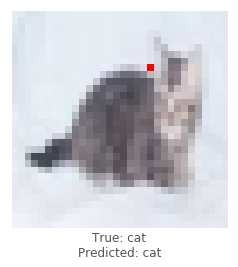

Attacking with target truck


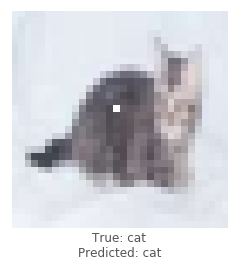

lecun_net - image 3086 - 10 / 10
Attacking with target airplane


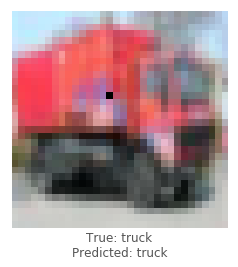

Attacking with target automobile


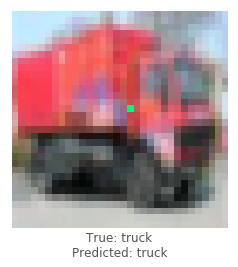

Attacking with target bird


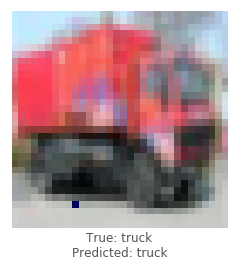

Attacking with target cat


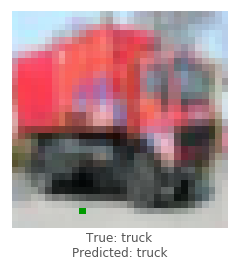

Attacking with target deer


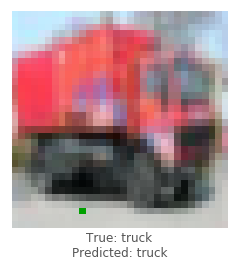

Attacking with target dog


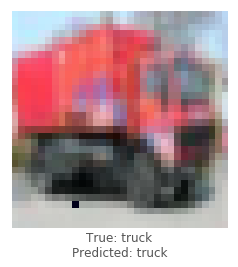

Attacking with target frog


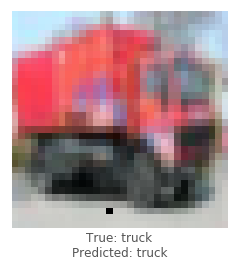

Attacking with target horse


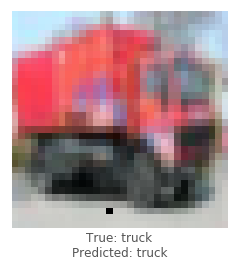

Attacking with target ship


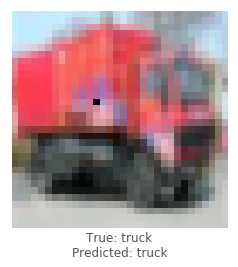

Attacking with target truck
resnet - image 141 - 1 / 10
Attacking with target airplane


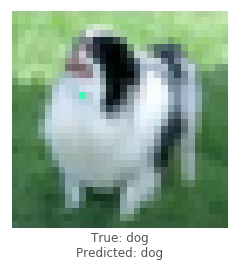

Attacking with target automobile


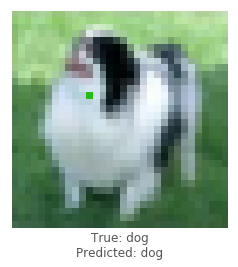

Attacking with target bird


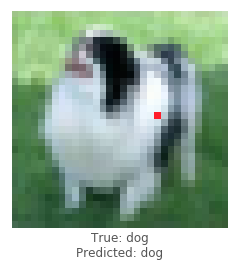

Attacking with target cat


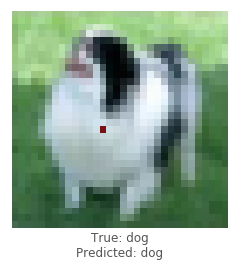

Attacking with target deer


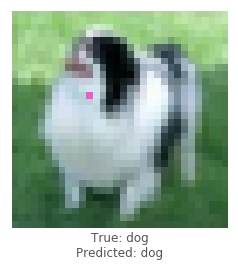

Attacking with target dog
Attacking with target frog


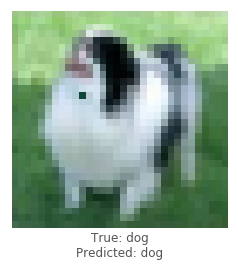

Attacking with target horse


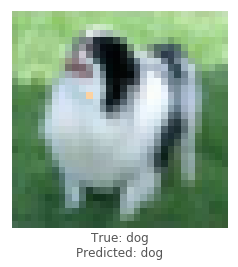

Attacking with target ship


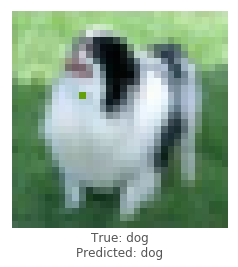

Attacking with target truck


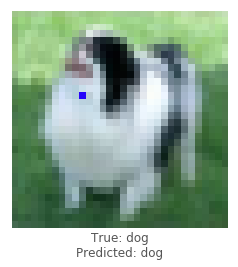

resnet - image 3419 - 2 / 10
Attacking with target airplane


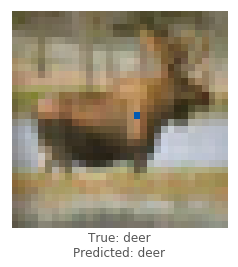

Attacking with target automobile


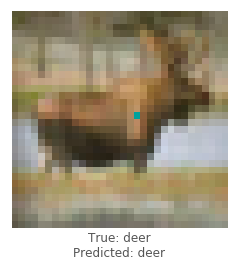

Attacking with target bird


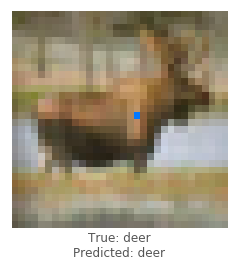

Attacking with target cat


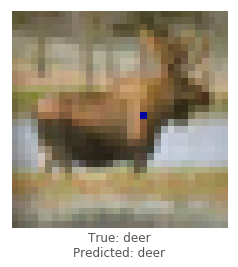

Attacking with target deer
Attacking with target dog


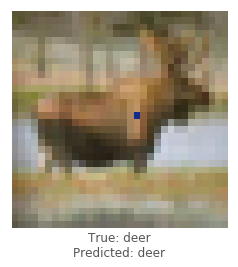

Attacking with target frog


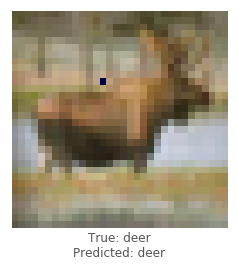

Attacking with target horse


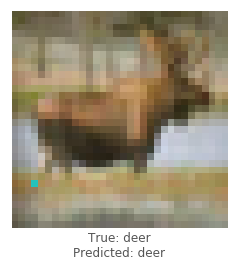

Attacking with target ship


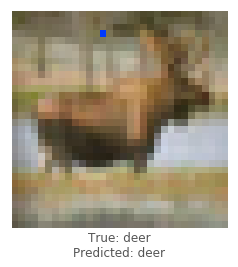

Attacking with target truck


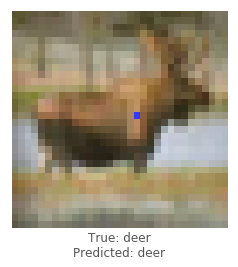

resnet - image 7550 - 3 / 10
Attacking with target airplane


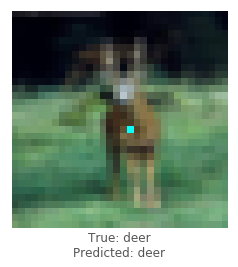

Attacking with target automobile


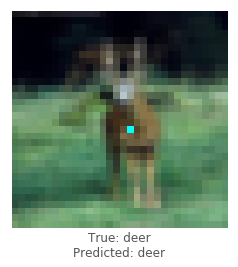

Attacking with target bird


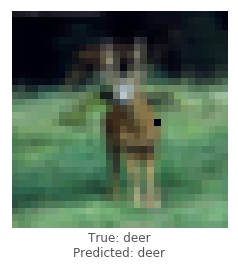

Attacking with target cat


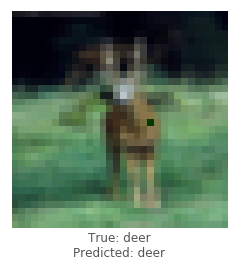

Attacking with target deer
Attacking with target dog


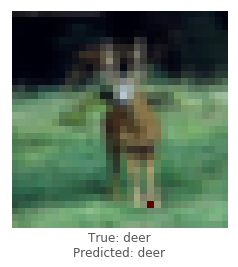

Attacking with target frog


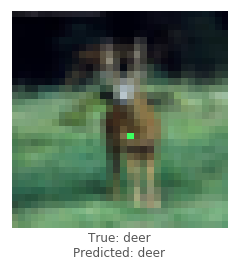

Attacking with target horse


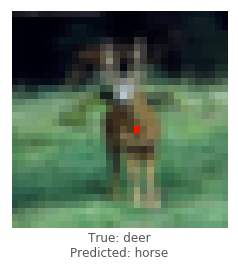

Attacking with target ship


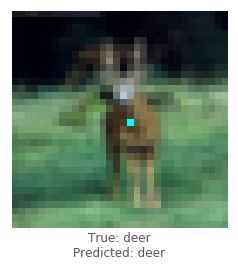

Attacking with target truck


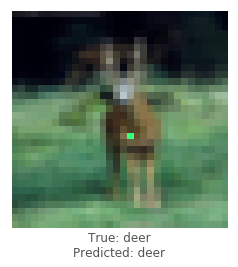

resnet - image 7472 - 4 / 10
Attacking with target airplane


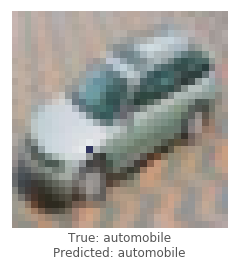

Attacking with target automobile
Attacking with target bird


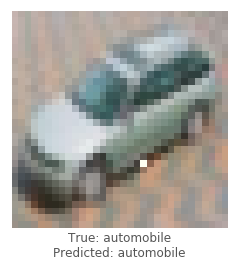

Attacking with target cat


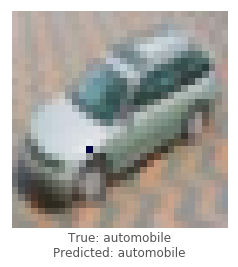

Attacking with target deer


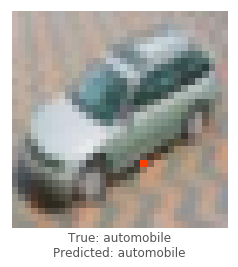

Attacking with target dog


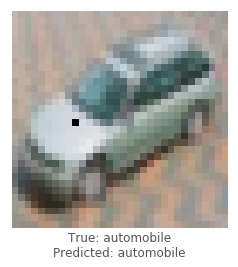

Attacking with target frog


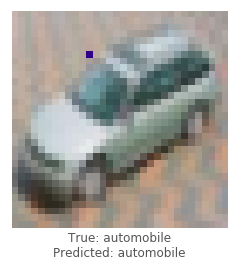

Attacking with target horse


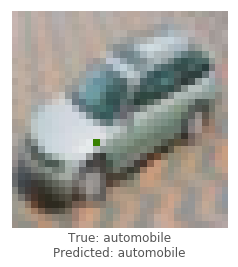

Attacking with target ship


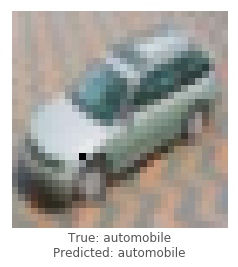

Attacking with target truck


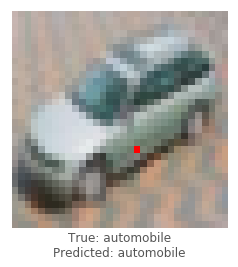

resnet - image 2186 - 5 / 10
Attacking with target airplane


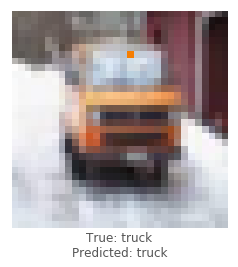

Attacking with target automobile


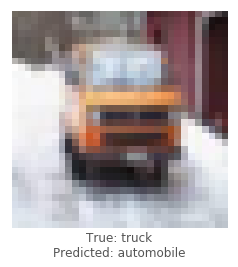

Attacking with target bird


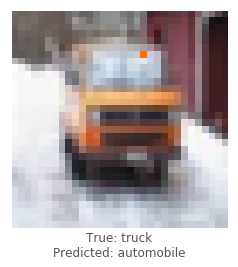

Attacking with target cat


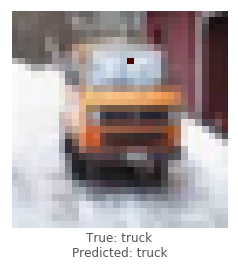

Attacking with target deer


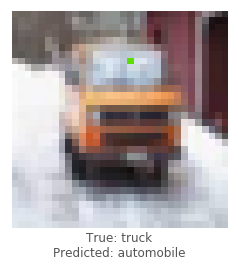

Attacking with target dog


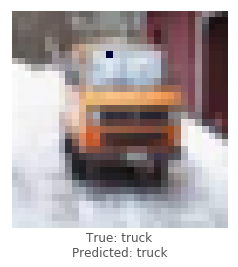

Attacking with target frog


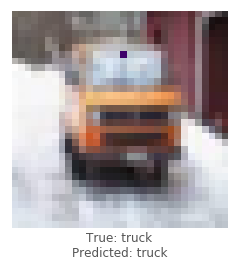

Attacking with target horse


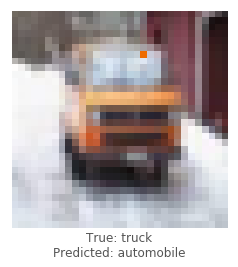

Attacking with target ship


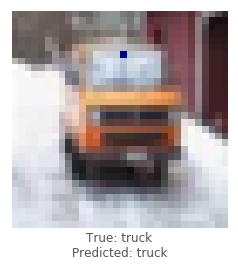

Attacking with target truck
resnet - image 981 - 6 / 10
Attacking with target airplane


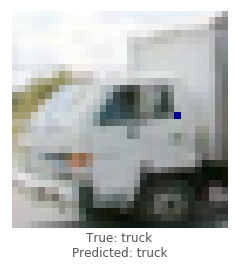

Attacking with target automobile


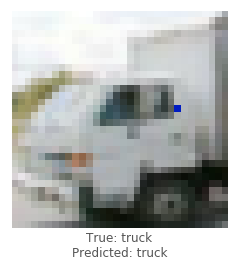

Attacking with target bird


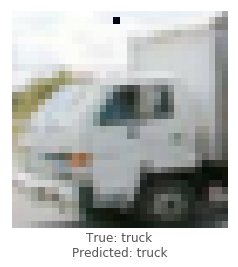

Attacking with target cat


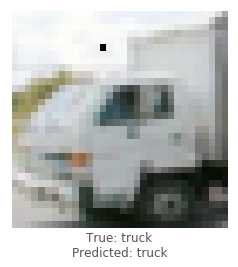

Attacking with target deer


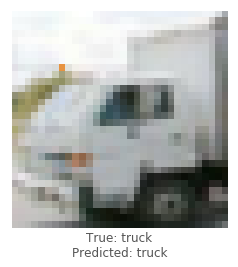

Attacking with target dog


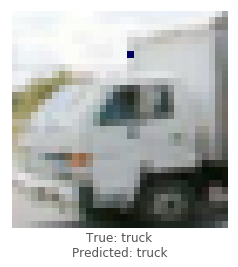

Attacking with target frog


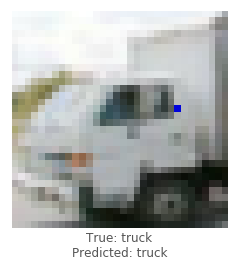

Attacking with target horse


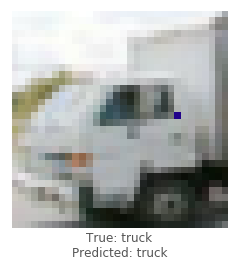

Attacking with target ship


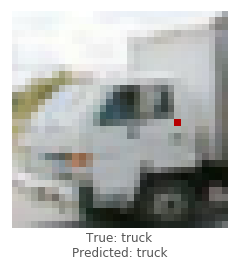

Attacking with target truck
resnet - image 7637 - 7 / 10
Attacking with target airplane


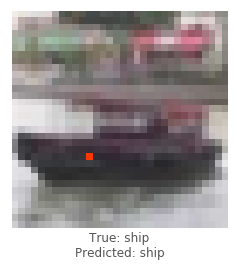

Attacking with target automobile


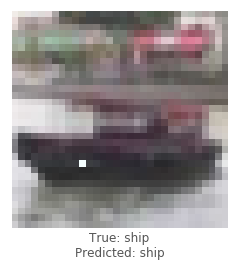

Attacking with target bird


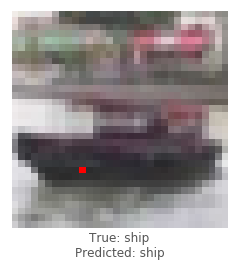

Attacking with target cat


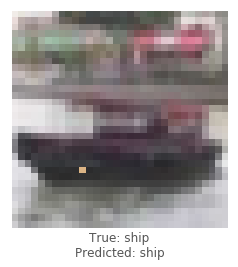

Attacking with target deer


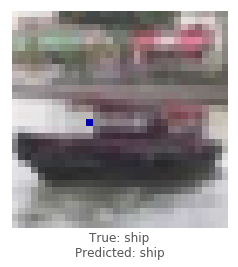

Attacking with target dog


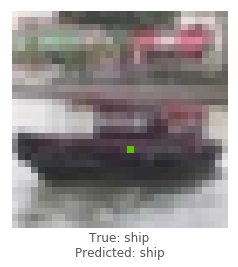

Attacking with target frog


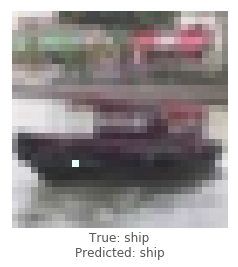

Attacking with target horse


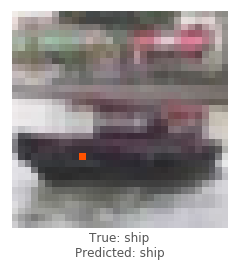

Attacking with target ship
Attacking with target truck


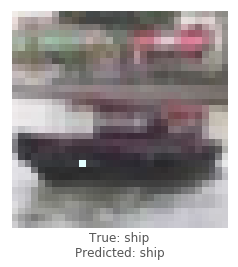

resnet - image 6344 - 8 / 10
Attacking with target airplane


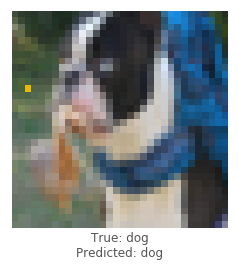

Attacking with target automobile


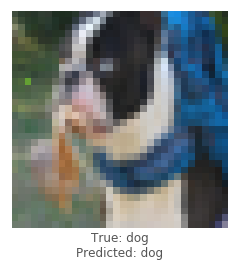

Attacking with target bird


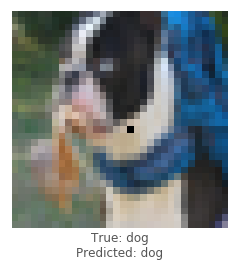

Attacking with target cat


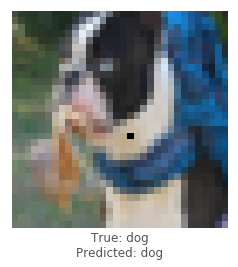

Attacking with target deer


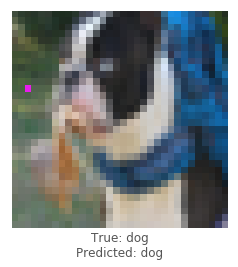

Attacking with target dog
Attacking with target frog


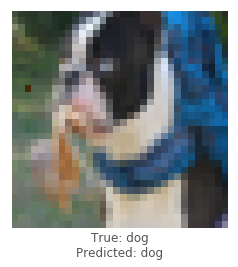

Attacking with target horse


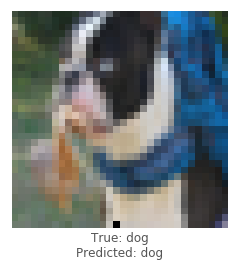

Attacking with target ship


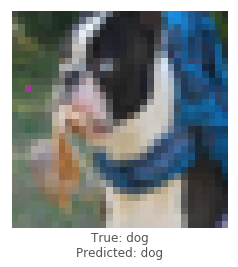

Attacking with target truck


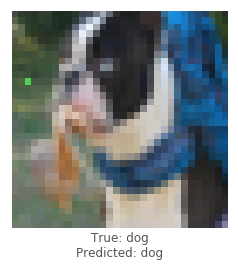

resnet - image 7958 - 9 / 10
Attacking with target airplane


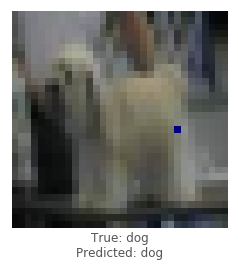

Attacking with target automobile


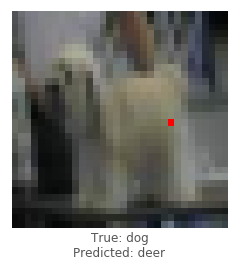

Attacking with target bird


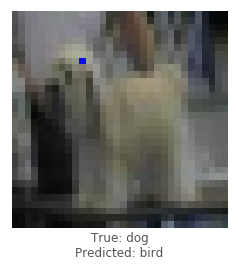

Attacking with target cat


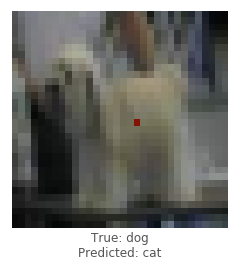

Attacking with target deer


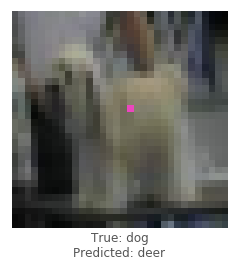

Attacking with target dog
Attacking with target frog


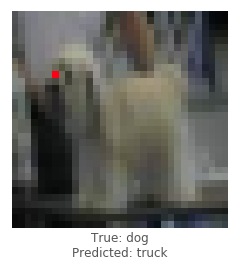

Attacking with target horse


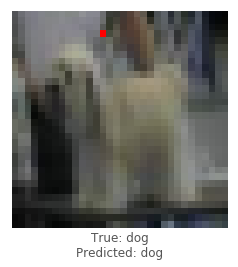

Attacking with target ship


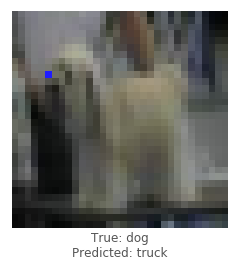

Attacking with target truck


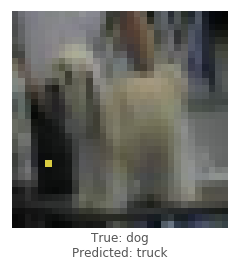

resnet - image 7864 - 10 / 10
Attacking with target airplane


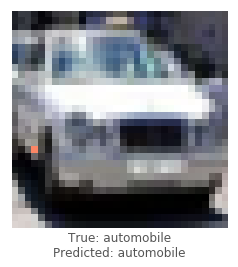

Attacking with target automobile
Attacking with target bird


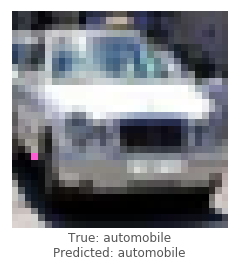

Attacking with target cat


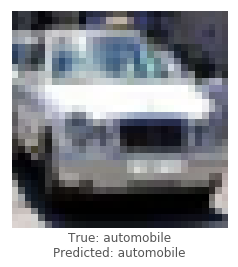

Attacking with target deer


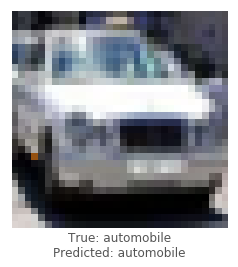

Attacking with target dog


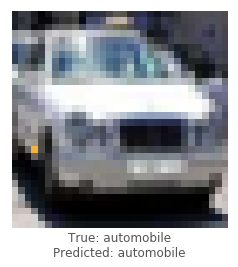

Attacking with target frog


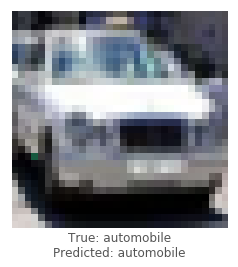

Attacking with target horse


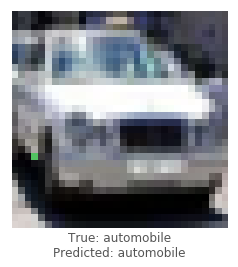

Attacking with target ship


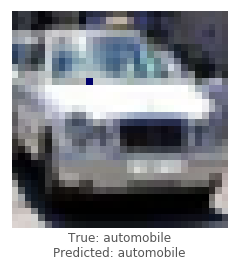

Attacking with target truck


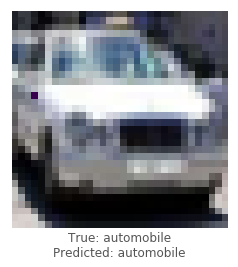

In [130]:
time_start=time()
targeted = attack_all(models, samples=10, targeted=True)
time_end=time()

In [138]:
targeted_time=time_end-time_start
print(targeted_time)

1756.817029953003


### Attack Statistics

Print the final results! 

In [132]:
# Load the results
untargeted, targeted = helper.load_results()

In [133]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [134]:
helper.attack_stats(untargeted_results, models, network_stats)

model  accuracy  pixels  attack_success_rate
0  lecun_net    0.7488       1                 0.49
1     resnet    0.9231       1                 0.29

#### Targeted

In [135]:
helper.attack_stats(targeted_results, models, network_stats)

model  accuracy  pixels  attack_success_rate
0  lecun_net    0.7488       1             0.222222
1     resnet    0.9231       1             0.133333

### Show some successful attacks

Plot 9 random successful attack images

Untargeted Attack


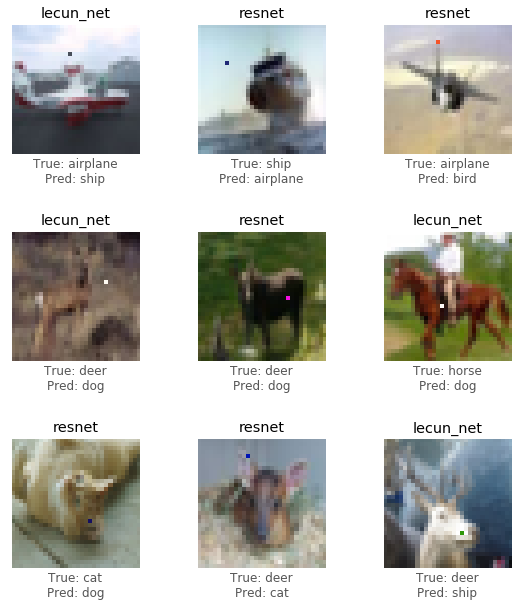

In [136]:
print('Untargeted Attack')
helper.visualize_attack(untargeted_results, class_names)

Targeted Attack


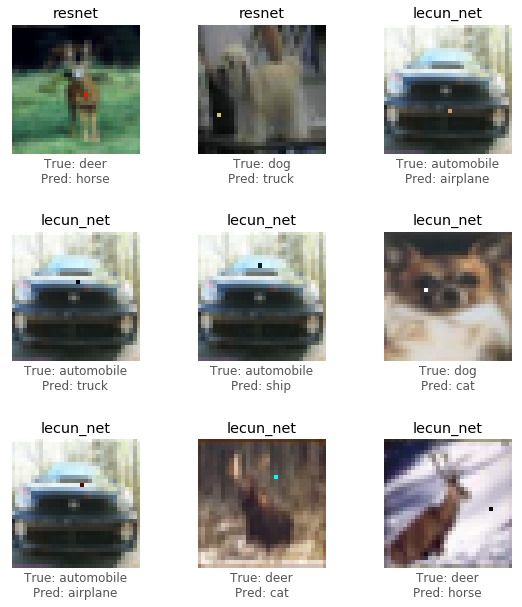

In [137]:
print('Targeted Attack')
helper.visualize_attack(targeted_results, class_names)

## Conclusions

It appears that the accuracy of a model is not strongly correlated with the chance of performing a successful attack on an image. Perhaps surprisingly, the purely convolutional model is the most resistant CNN to these types of attacks. In addition, the capsule network CapsNet has the lowest attack success rate out of all the models, although it is still vulnerable to attack.

## Credits
 -  This implemenation is based off of the original paper describing the one pixel attack: https://arxiv.org/abs/1710.08864
 - Base code for iPython notebook: https://github.com/09rohanchopra/cifar10
 - Keras Cifar10 models: https://github.com/BIGBALLON/cifar-10-cnn
 - Scipy's differential evolution implementation: https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html
 - State of the art: https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems
 - CapsNet Keras: https://github.com/XifengGuo/CapsNet-Keras
 - CapsNet with Cifar: https://github.com/theblackcat102/dynamic-routing-capsule-cifar